# Prophet とNeuralProphet で時系列分析をしてみる

In [827]:
# ライブラリーの読み込み
import pandas as pd
from autofeat import AutoFeatRegressor                 #AutoFeat
from sklearn.model_selection import train_test_split   #データセットの分割（学習データとテストデータ）
from sklearn.datasets import fetch_california_housing  #サンプルデータ
from sklearn.linear_model import LinearRegression      #線形モデル
from sklearn.metrics import r2_score                   #精度評価で利用（R2:決定係数）
import numpy as np


# ライブラリーの読み込み
import pandas as pd    #基本ライブラリー
from fbprophet import Prophet                   #Prophet
from neuralprophet import NeuralProphet         #NeuralProphet
from sklearn.metrics import mean_absolute_error #評価指標MAE
from statistics import mean                     #平均値の計算
import matplotlib.pyplot as plt                 #グラフ描写
import pandas.tseries.offsets as offsets

from datetime import datetime as dt
#from datetime import timedelta
import datetime
from dateutil.relativedelta import relativedelta

In [828]:
#データセット
dollar_ind_his = pd.read_csv("input_data/米ドル指数_2019-2021.csv", encoding="utf_8")
eur_usd_his = pd.read_csv("input_data/EUR_USD_2019-2021.csv", encoding="utf_8")

dollar_ind_his = dollar_ind_his.set_index("日付け")
eur_usd_his = eur_usd_his.set_index("日付け")



In [829]:
#データセット　月次
dollar_ind_monthly_1975 = pd.read_csv("input_data/米ドル指数_monthly_1975-2021.csv", encoding="utf_8")
eur_usd_monthly_1975 = pd.read_csv("input_data/EUR_USD_monthly_1975-2021.csv", encoding="utf_8")

#dollar_ind_monthly_1975 = dollar_ind_monthly_1975.set_index("日付け")
#eur_usd_monthly_1975 = eur_usd_monthly_1975.set_index("日付け")

#dollar_ind_monthly_1975["date"] = pd.to_datetime(dollar_ind_monthly_1975.index, format='%m月 %Y')
#dollar_ind_monthly_1975 = dollar_ind_monthly_1975.sort_values(by = "date")

def get_date_seri(df):
    for index in range(len(df)):
        #月の文字列を抽出
        date_str = df.loc[ index, ["日付け"]][0].replace(" ","")
        slice_num = date_str.find("月")
        month_num = int(date_str[:slice_num])
        year_num = int(date_str[slice_num+1:])
        df.loc[ index, ["date"]] =  str(year_num)+"年" + str(month_num)+"月"
    return df
    
dollar_ind_monthly_1975 = get_date_seri(dollar_ind_monthly_1975)
dollar_ind_monthly_1975["date"] = pd.to_datetime(dollar_ind_monthly_1975["date"], format='%Y年%m月')
eur_usd_monthly_1975 = get_date_seri(eur_usd_monthly_1975)
eur_usd_monthly_1975["date"] = pd.to_datetime(eur_usd_monthly_1975["date"], format='%Y年%m月')
eur_usd_monthly_1975

,日付け,終値,始値,高値,安値,前日比%,date
0,２月 1975,1.3847,1.3847,1.3847,1.3847,2.78%,1975-02-01
1,３月 1975,1.3561,1.3561,1.3561,1.3561,-2.07%,1975-03-01
2,４月1975,1.3524,1.3524,1.3524,1.3524,-0.27%,1975-04-01
3,５月1975,1.3708,1.3708,1.3708,1.3708,1.36%,1975-05-01
4,６月 1975,1.3622,1.3622,1.3622,1.3622,-0.63%,1975-06-01
...,...,...,...,...,...,...,...
558,８月 2021,1.1807,1.1864,1.1901,1.1664,-0.53%,2021-08-01
559,９月 2021,1.1581,1.1810,1.1910,1.1562,-1.91%,2021-09-01
560,10月 2021,1.1561,1.1582,1.1693,1.1524,-0.17%,2021-10-01
561,11月 2021,1.1336,1.1559,1.1617,1.1185,-1.95%,2021-11-01


In [830]:
#データセット　週次
dollar_ind_weekly_1975 = pd.read_csv("input_data/米ドル指数_weekly_1975-2021.csv", encoding="utf_8")
eur_usd_weekly_1975 = pd.read_csv("input_data/EUR_USD_weekly_1975-2021.csv", encoding="utf_8")

def get_date_seri(df):
    for index in range(len(df)):
        #月の文字列を抽出
        date_str = df.loc[ index, ["日付け"]][0].replace(" ","")
        slice_num = date_str.find("月")
        month_num = int(date_str[:slice_num])
        year_num = int(date_str[slice_num+1:])
        df.loc[ index, ["date"]] =  str(year_num)+"年" + str(month_num)+"月"
    return df
    

dollar_ind_weekly_1975["date"] = pd.to_datetime(dollar_ind_weekly_1975["日付け"], format='%Y年%m月%d日')
eur_usd_weekly_1975["date"] = pd.to_datetime(eur_usd_weekly_1975["日付け"], format='%Y年%m月%d日')
dollar_ind_weekly_1975

,日付け,終値,始値,高値,安値,出来高,前日比%,date
0,1971年01月10日,120.44,120.53,120.53,120.44,-,-0.07%,1971-01-10
1,1971年01月17日,120.31,120.41,120.41,120.31,-,-0.11%,1971-01-17
2,1971年01月24日,120.24,120.27,120.27,120.24,-,-0.06%,1971-01-24
3,1971年01月31日,120.26,120.26,120.28,120.24,-,0.02%,1971-01-31
4,1971年02月07日,120.29,120.26,120.29,120.25,-,0.02%,1971-02-07
...,...,...,...,...,...,...,...,...
2655,2021年11月28日,96.12,96.07,96.64,95.52,-,0.03%,2021-11-28
2656,2021年12月05日,96.10,96.15,96.59,95.85,-,-0.02%,2021-12-05
2657,2021年12月12日,96.57,96.05,96.91,95.85,-,0.49%,2021-12-12
2658,2021年12月19日,96.02,96.67,96.69,95.99,-,-0.57%,2021-12-19


In [ ]:
#ラグと移動平均作成

In [43]:

dollar_ind_his.columns = [ "dollar_ind"+i for i in dollar_ind_his.columns ]
eur_usd_his.columns = [ "eur_usd"+i for i in eur_usd_his.columns ]
eur_usd_his

,eur_usd終値,eur_usd始値,eur_usd高値,eur_usd安値,eur_usd前日比%
日付け,,,,,
2021年12月31日,1.1368,1.1324,1.1387,1.1302,0.40%
2021年12月30日,1.1323,1.1349,1.1360,1.1298,-0.22%
2021年12月29日,1.1348,1.1310,1.1370,1.1273,0.34%
2021年12月28日,1.1309,1.1329,1.1335,1.1289,-0.14%
2021年12月27日,1.1325,1.1318,1.1335,1.1302,0.07%
...,...,...,...,...,...
2019年01月07日,1.1476,1.1392,1.1485,1.1392,0.71%
2019年01月04日,1.1395,1.1393,1.1422,1.1345,0.01%
2019年01月03日,1.1394,1.1345,1.1413,1.1309,0.45%


In [44]:

feat_df = feat_df.join(eur_usd_his)
feat_df = feat_df.drop(["始値","終値","安値","出来高","前日比%","dollar_ind出来高", "dollar_ind前日比%", "eur_usd前日比%"] , axis=1)
feat_df = feat_df.dropna(how="any")
feat_df = feat_df.replace("%", "" , regex = True)
feat_df = feat_df.astype("float")
feat_df

,高値,dollar_ind終値,dollar_ind始値,dollar_ind高値,dollar_ind安値,eur_usd終値,eur_usd始値,eur_usd高値,eur_usd安値
日付け,,,,,,,,,
2021年12月31日,77.08,95.67,95.99,96.11,95.57,1.1368,1.1324,1.1387,1.1302
2021年12月30日,77.44,95.97,95.89,96.22,95.86,1.1323,1.1349,1.1360,1.1298
2021年12月29日,77.37,95.93,96.15,96.39,95.76,1.1348,1.1310,1.1370,1.1273
2021年12月28日,76.92,96.20,96.07,96.28,96.00,1.1309,1.1329,1.1335,1.1289
2021年12月27日,76.09,96.09,96.15,96.26,96.05,1.1325,1.1318,1.1335,1.1302
...,...,...,...,...,...,...,...,...,...
2019年01月07日,49.79,95.67,96.16,96.16,95.64,1.1476,1.1392,1.1485,1.1392
2019年01月04日,49.22,96.18,96.28,96.61,96.05,1.1395,1.1393,1.1422,1.1345
2019年01月03日,47.49,96.31,96.72,96.75,96.21,1.1394,1.1345,1.1413,1.1309


In [45]:
feat_df["date"] = pd.to_datetime(feat_df.index, format='%Y年%m月%d日')

feat_df = feat_df.sort_values(by = "date")
feat_df

,高値,dollar_ind終値,dollar_ind始値,dollar_ind高値,dollar_ind安値,eur_usd終値,eur_usd始値,eur_usd高値,eur_usd安値,date
日付け,,,,,,,,,,
2019年01月01日,45.95,96.17,96.15,96.32,95.65,1.1464,1.1466,1.1481,1.1425,2019-01-01
2019年01月02日,47.78,96.82,96.14,96.96,95.82,1.1343,1.1464,1.1499,1.1325,2019-01-02
2019年01月03日,47.49,96.31,96.72,96.75,96.21,1.1394,1.1345,1.1413,1.1309,2019-01-03
2019年01月04日,49.22,96.18,96.28,96.61,96.05,1.1395,1.1393,1.1422,1.1345,2019-01-04
2019年01月07日,49.79,95.67,96.16,96.16,95.64,1.1476,1.1392,1.1485,1.1392,2019-01-07
...,...,...,...,...,...,...,...,...,...,...
2021年12月27日,76.09,96.09,96.15,96.26,96.05,1.1325,1.1318,1.1335,1.1302,2021-12-27
2021年12月28日,76.92,96.20,96.07,96.28,96.00,1.1309,1.1329,1.1335,1.1289,2021-12-28
2021年12月29日,77.37,95.93,96.15,96.39,95.76,1.1348,1.1310,1.1370,1.1273,2021-12-29


In [49]:
#ラグ特徴量を作成
lag_df = feat_df.loc[:, ["高値"]].copy()


df = lag_df
lags = [i*7 for i in range(1, 53)]#ラグに使用する値のリスト
for lag in lags:
    df = pd.concat( [df,df['高値'].shift(lag).rename('高値_lag_'+str(lag))],axis=1)
lag_of_y = df
lag_of_y

,高値,高値_lag_7,高値_lag_14,高値_lag_21,高値_lag_28,高値_lag_35,高値_lag_42,高値_lag_49,高値_lag_56,高値_lag_63,...,高値_lag_301,高値_lag_308,高値_lag_315,高値_lag_322,高値_lag_329,高値_lag_336,高値_lag_343,高値_lag_350,高値_lag_357,高値_lag_364
日付け,,,,,,,,,,,,,,,,,,,,,
2019年01月01日,45.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019年01月02日,47.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019年01月03日,47.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019年01月04日,49.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019年01月07日,49.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021年12月27日,76.09,71.66,70.15,78.65,81.81,81.80,84.51,83.87,78.89,76.67,...,39.74,41.29,40.86,40.64,40.34,39.53,43.50,42.99,42.22,41.57
2021年12月28日,76.92,72.99,73.03,78.65,80.69,82.67,83.21,83.74,80.11,75.79,...,39.83,41.05,40.35,40.80,41.22,39.59,43.42,43.03,42.33,41.39
2021年12月29日,77.37,72.26,73.00,72.93,79.36,84.63,83.74,84.25,82.18,76.07,...,39.01,41.22,41.33,40.70,41.49,38.45,43.57,42.79,42.94,40.55


In [50]:
# 移動平均を算出する（現在月含まない）
rolling_df = feat_df.loc[:, ["高値"]].copy()


df = rolling_df
windows = [i*7 for i in range(1, 53)]
for window in windows:
    df = pd.concat([ df, df["高値"].rolling(window).mean().rename("高値_移動平均_"+str(window))],axis=1 )
df

,高値,高値_移動平均_7,高値_移動平均_14,高値_移動平均_21,高値_移動平均_28,高値_移動平均_35,高値_移動平均_42,高値_移動平均_49,高値_移動平均_56,高値_移動平均_63,...,高値_移動平均_301,高値_移動平均_308,高値_移動平均_315,高値_移動平均_322,高値_移動平均_329,高値_移動平均_336,高値_移動平均_343,高値_移動平均_350,高値_移動平均_357,高値_移動平均_364
日付け,,,,,,,,,,,,,,,,,,,,,
2019年01月01日,45.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019年01月02日,47.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019年01月03日,47.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019年01月04日,49.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019年01月07日,49.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021年12月27日,76.09,72.867143,72.747143,72.267143,73.981429,75.734571,77.029762,78.086122,78.560357,78.472381,...,65.092591,64.545812,64.021238,63.503913,63.021337,62.513839,62.103411,61.725686,61.354426,60.981264
2021年12月28日,76.92,73.428571,73.025000,72.184762,73.846786,75.570286,76.880000,77.946939,78.503393,78.490317,...,65.215814,64.662273,64.137333,63.616087,63.129848,62.624940,62.201079,61.822514,61.451317,61.078874
2021年12月29日,77.37,74.158571,73.337143,72.396190,73.775714,75.362857,76.728333,77.806531,78.417500,78.510952,...,65.343256,64.779643,64.251746,63.729969,63.238906,62.740774,62.299621,61.921314,61.547759,61.180027


In [48]:
#様々な特徴量を作成する
#目的変数のラグと移動平均
#説明変数のラグと移動平均


In [6]:
import optuna.integration.lightgbm as LGB_optuna

In [7]:
import lightgbm as lgb

# モデル構築　prophetとneuralprophet

Text(0.5, 0, 'Day')

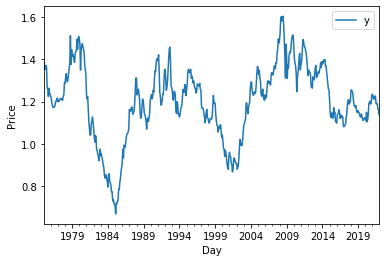

In [857]:
#可視化

#df1 = feat_df.loc[: ,["高値","date"]].rename(columns={"高値":"y" , "date":"ds"})
df1 = eur_usd_monthly_1975.loc[: ,["高値","date"]].rename(columns={"高値":"y" , "date":"ds"})
#df1 = dollar_ind_monthly_1975.loc[: ,["高値","date"]].rename(columns={"高値":"y" , "date":"ds"})



df1.set_index("ds").plot()
#plt.title('Page Views of Peyton Manning') #グラフタイトル
plt.ylabel('Price')             #タテ軸のラベル
plt.xlabel('Day')                          #ヨコ軸のラベル


# 月次を使って分析

Text(0.5, 0, 'Day')

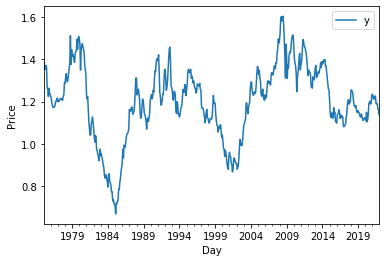

In [858]:


df = eur_usd_monthly_1975
#df = dollar_ind_monthly_1975
target_price = "高値"



df1 = df.loc[: ,["高値","date"]].rename(columns={"高値":"y" , "date":"ds"})

#前処理
#df["date"] = pd.to_datetime(df.index, format='%Y-%m-%d')
df = df.sort_values(by = "date")
df1 = df.loc[: ,[target_price,"date"]].rename(columns={target_price:"y" , "date":"ds"})#高値で予測

#変化を描画し、周期性がありそうか確認
df1.set_index("ds").plot()
#plt.title('Page Views of Peyton Manning') #グラフタイトル
plt.ylabel('Price')             #タテ軸のラベル
plt.xlabel('Day')                          #ヨコ軸のラベル



# Prophet 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]

  x[:, None]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a num

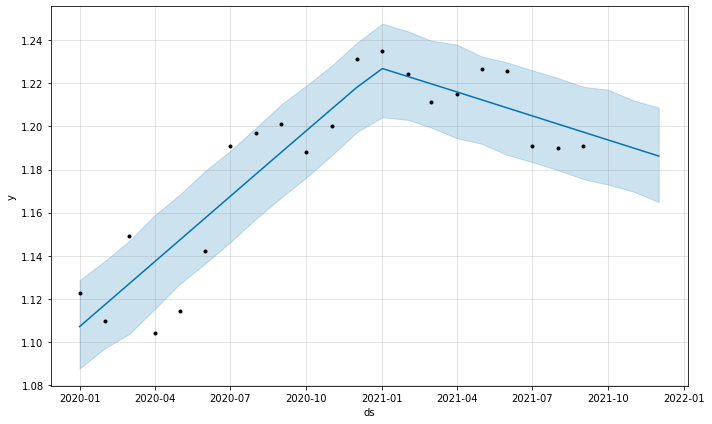

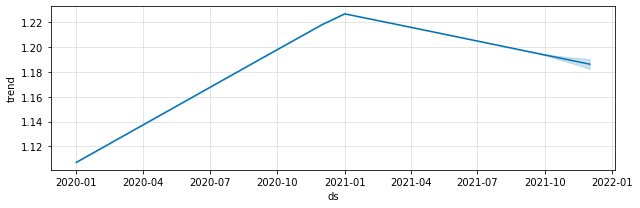

In [880]:
start_date_to_use = "2020-01-01"
test_length = 3

df = eur_usd_monthly_1975
#df = dollar_ind_monthly_1975



df1 = df.loc[: ,["高値","date"]].rename(columns={"高値":"y" , "date":"ds"})
#利用期間
df1 = df1[df1["ds"] >= dt.strptime(start_date_to_use, "%Y-%m-%d")]

# 学習データとテストデータの分割
df1_train = df1.iloc[:-test_length]
df1_test = df1.iloc[-test_length:]


# Prophet 予測モデル構築
df1_prophet_model = Prophet(seasonality_mode='multiplicative')
df1_prophet_model.fit(df1_train)

# Prophet 予測モデルの精度検証用データの生成
df1_future = df1_prophet_model.make_future_dataframe(periods=test_length, freq='M')
#日付が１日ズレるので修正する
for index in df1_future.index[-test_length:]:
    df1_future.loc[index ] = df1_future.loc[index ] + datetime.timedelta(days=1)
df1_pred = df1_prophet_model.predict(df1_future)
df1_pred["y"] = list(df1["y"])

# Prophet 予測モデルの予測結果（学習データ期間＋テストデータ期間）
df1_pred_plot = df1_prophet_model.plot(df1_pred)         #予想値（点は学習データの実測値）
df1_pmpc = df1_prophet_model.plot_components(df1_pred)   #モデルの要素分解

# テストデータに予測値を結合
df1_test = pd.merge( df1_pred.loc[: , ["ds", "yhat"]], df1_test, on = "ds" , how = "inner")
df1_test = df1_test.rename(columns = {"yhat":'Prophet Predict'})


MAE:
0.033372494914486905
MAPE:
2.895736852310029


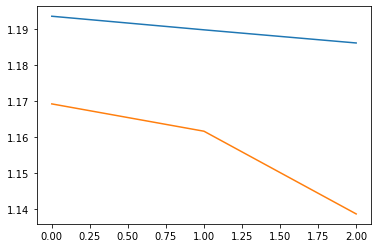

In [881]:
# Prophet 予測モデルの精度検証（テストデータ期間）
print('MAE:')
print(mean_absolute_error(df1_test['y'], df1_test['Prophet Predict'])) 
print('MAPE:')
print(mean(abs(df1_test['y'] - df1_test['Prophet Predict'])/df1_test['y']) *100)

for col in ["Prophet Predict","y"]:
    plt.plot(df1_test[col])

# NeuralProphet

In [882]:
# NeuralProphet 予測モデル構築
df1_nprophet_model = NeuralProphet(seasonality_mode='multiplicative')
df1_nprophet_model_result = df1_nprophet_model.fit(df1_train, freq="M")

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 470
INFO:NP.config:Auto-set epochs to 470


  0%|          | 0/174 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.28E-02, min: 9.11E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.28E-02, min: 9.11E+00


  0%|          | 0/174 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.68E-02, min: 1.16E+01
INFO:NP.utils_torch:lr-range-test results: steep: 4.68E-02, min: 1.16E+01


  0%|          | 0/174 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.15E-02, min: 5.79E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.15E-02, min: 5.79E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.68E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 4.68E-02
Epoch[470/470]: 100%|██████████| 470/470 [00:05<00:00, 93.02it/s, SmoothL1Loss=0.00561, MAE=0.0116, RMSE=0.0133, RegLoss=0] 


WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]

  x[:, None]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]

  y = y[:, np.newaxis]



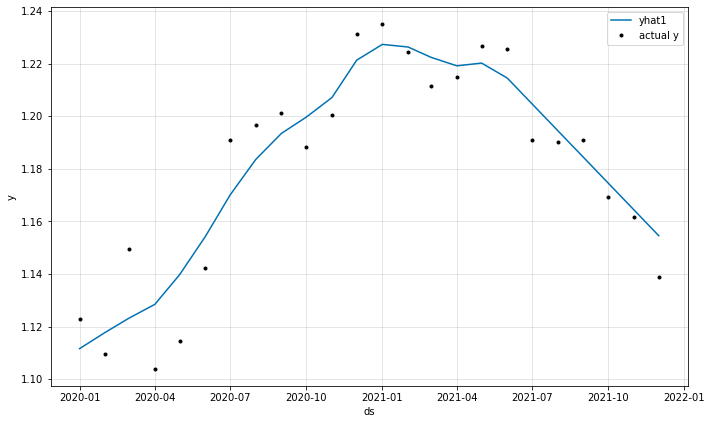

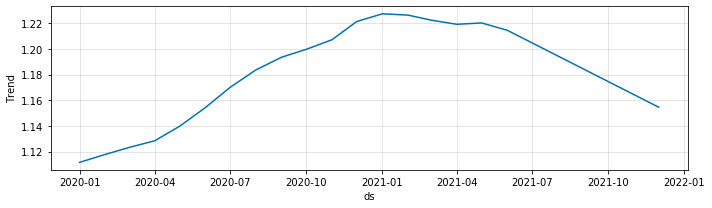

In [883]:
# NeuralProphet 予測モデルの精度検証用データの生成
df1_future = df1_nprophet_model.make_future_dataframe(df1_train, 
                                                      periods = test_length, 
                                                      n_historic_predictions=len(df1_train))
#日付が１日ズレるので修正する
for index in df1_future.index[-test_length:]:
    df1_future.loc[index ] = df1_future.loc[index ] + datetime.timedelta(days=1)

df1_pred = df1_nprophet_model.predict(df1_future)
df1_pred["y"] = list(df1["y"])

# NeuralProphet 予測モデルの予測結果（学習データ期間＋テストデータ期間）
df1_pred_plot = df1_nprophet_model.plot(df1_pred)         #予想値（点は学習データの実測値）
df1_pmpc = df1_nprophet_model.plot_components(df1_pred)   #モデルの要素分解

# テストデータに予測値を結合
df1_test = pd.merge( df1_pred.loc[: , ["ds", "yhat1"]], df1_test, on = "ds" , how = "inner")
df1_test = df1_test.rename(columns = {"yhat1":'NeuralProphet Predict'})

MAE(Prophet):
0.033372494914486905
MAE(NeuralProphet):
0.007909688250223793
----------------------------
MAPE(Prophet):
2.895736852310029
MAPE(NeuralProphet):
0.6890814694700808


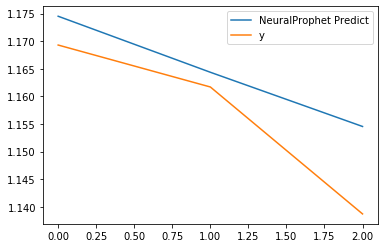

In [884]:


# NeuralProphet 予測モデルの精度検証（テストデータ期間）
print('MAE(Prophet):')
print(mean_absolute_error(df1_test['y'], df1_test['Prophet Predict'])) 
print('MAE(NeuralProphet):')
print(mean_absolute_error(df1_test['y'], df1_test['NeuralProphet Predict'])) 
print('----------------------------')
print('MAPE(Prophet):')
print(mean(abs(df1_test['y'] - df1_test['Prophet Predict'])/df1_test['y']) *100)
print('MAPE(NeuralProphet):')
print(mean(abs(df1_test['y'] - df1_test['NeuralProphet Predict'])/df1_test['y']) *100)
for col in ["NeuralProphet Predict","y"]:
    plt.plot(df1_test[col] , label = col)
plt.legend()

In [709]:
df1_test

,ds,NeuralProphet Predict,Prophet Predict,y
0,2021-10-01,94.091011,93.591761,94.56
1,2021-11-01,94.406990,94.064278,96.94
2,2021-12-01,93.990311,92.999849,96.91


In [581]:
df1_pred

,ds,y,yhat1,residual1,trend,season_yearly
0,2012-01-01,1.3232,1.337485,0.014285,1.324250,0.054454
1,2012-02-01,1.3487,1.341658,-0.007042,1.323368,0.075530
2,2012-03-01,1.3386,1.326890,-0.01171,1.322542,0.018014
3,2012-04-01,1.3382,1.319898,-0.018302,1.321659,-0.007324
4,2012-05-01,1.3284,1.319999,-0.008401,1.320805,-0.003362
...,...,...,...,...,...,...
115,2021-08-01,1.1901,1.226414,0.036314,1.235857,-0.061059
116,2021-09-01,1.1910,1.240201,0.049201,1.241706,-0.009378
117,2021-10-01,1.1693,1.252812,NaN,1.247365,0.032779
118,2021-11-01,1.1617,1.248028,NaN,1.253214,-0.030149


In [ ]:
#探索・・・最もフィットする期間を求める関数

In [610]:
#予測した期間の予測値のdfを返す関数

def get_predict_df(df, start_date_to_use ,test_length):
    df1 = df.loc[: ,["高値","date"]].rename(columns={"高値":"y" , "date":"ds"})
    #利用期間
    df1 = df1[df1["ds"] >= dt.strptime(start_date_to_use, "%Y-%m-%d")]

    # 学習データとテストデータの分割
    df1_train = df1.iloc[:-test_length]
    df1_test = df1.iloc[-test_length:]


    # Prophet 予測モデル構築
    df1_prophet_model = Prophet(seasonality_mode='multiplicative')
    df1_prophet_model.fit(df1_train)

    # Prophet 予測モデルの精度検証用データの生成
    df1_future = df1_prophet_model.make_future_dataframe(periods=test_length, freq='M')
    #日付が１日ズレるので修正する
    for index in df1_future.index[-test_length:]:
        df1_future.loc[index ] = df1_future.loc[index ] + datetime.timedelta(days=1)
    df1_pred = df1_prophet_model.predict(df1_future)
    df1_pred["y"] = list(df1["y"])

    # Prophet 予測モデルの予測結果（学習データ期間＋テストデータ期間）
    #df1_pred_plot = df1_prophet_model.plot(df1_pred)         #予想値（点は学習データの実測値）
    #df1_pmpc = df1_prophet_model.plot_components(df1_pred)   #モデルの要素分解

    # テストデータに予測値を結合
    df1_test = pd.merge( df1_pred.loc[: , ["ds", "yhat"]], df1_test, on = "ds" , how = "inner")
    df1_test = df1_test.rename(columns = {"yhat":'Prophet Predict'})
    
    #全期間の予測結果をpfとnpf両方出力するためのdf
    pred_all_df = df1_pred.loc[: , ["ds","y","yhat"]].copy()
    pred_all_df = pred_all_df.rename(columns = {"yhat":'Prophet Predict'})

    # NeuralProphet 予測モデル構築
    df1_nprophet_model = NeuralProphet(seasonality_mode='multiplicative')
    df1_nprophet_model_result = df1_nprophet_model.fit(df1_train, freq="M")

    # NeuralProphet 予測モデルの精度検証用データの生成
    df1_future = df1_nprophet_model.make_future_dataframe(df1_train, 
                                                          periods = test_length, 
                                                          n_historic_predictions=len(df1_train))
    #日付が１日ズレるので修正する
    for index in df1_future.index[-test_length:]:
        df1_future.loc[index ] = df1_future.loc[index ] + datetime.timedelta(days=1)

    df1_pred = df1_nprophet_model.predict(df1_future)
    df1_pred["y"] = list(df1["y"])

    # NeuralProphet 予測モデルの予測結果（学習データ期間＋テストデータ期間）
    #df1_pred_plot = df1_nprophet_model.plot(df1_pred)         #予想値（点は学習データの実測値）
    #df1_pmpc = df1_nprophet_model.plot_components(df1_pred)   #モデルの要素分解

    # テストデータに予測値を結合
    df1_test = pd.merge( df1_pred.loc[: , ["ds", "yhat1"]], df1_test, on = "ds" , how = "inner")
    df1_test = df1_test.rename(columns = {"yhat1":'NeuralProphet Predict'})
    
    #全期間の予測結果をpfとnpf両方出力するためのdf
    pred_all_df = pd.merge(pred_all_df, df1_pred.loc[: , ["ds","yhat1"]].copy(), on = "ds")
    pred_all_df = pred_all_df.rename(columns = {"yhat1":'NeuralProphet Predict'})
    
    return df1_test ,pred_all_df

In [611]:

def get_all_predict_df(df, start_date_overall ,test_length ):
    all_predict_df = pd.DataFrame()
    for add_years in range(0,50,2):
        start_date_to_use = dt.strptime(start_date_overall, "%Y-%m-%d")+ relativedelta(years=add_years) 
        df_test ,df_pred = get_predict_df(df, start_date_to_use.strftime('%Y-%m-%d') ,test_length)
        df_pred["start_date_to_use"] = start_date_to_use
        all_predict_df = pd.concat([all_predict_df, df_pred], axis=0)
    return all_predict_df

In [612]:
start_date_overall = "1972-01-01"
test_length = 3

#df = eur_usd_monthly_1975
#df = dollar_ind_monthly_1975


eur_usd_various_term_predict = get_all_predict_df(eur_usd_monthly_1975, start_date_overall ,test_length )
dollar_ind_various_term_predict = get_all_predict_df(dollar_ind_monthly_1975, start_date_overall ,test_length )




INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 208
INFO:NP.config:Auto-set epochs to 208


  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.72E-01, min: 3.10E-02
INFO:NP.utils_torch:lr-range-test results: steep: 4.72E-01, min: 3.10E-02


  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.32E-01, min: 2.38E-02
INFO:NP.utils_torch:lr-range-test results: steep: 4.32E-01, min: 2.38E-02


  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.96E-01, min: 2.84E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.96E-01, min: 2.84E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.32E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 4.32E-01
Epoch[208/208]: 100%|██████████| 208/208 [00:16<00:00, 12.70it/s, SmoothL1Loss=0.00639, MAE=0.0722, RMSE=0.0885, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.68E+01, min: 5.05E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.68E+01, min: 5.05E+00


  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.33E+01, min: 1.24E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.33E+01, min: 1.24E+00


  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.14E-01, min: 2.98E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.14E-01, min: 2.98E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.02E+00
INFO:NP.forecaster:lr-range-test selected learning rate: 6.02E+00
Epoch[208/208]: 100%|██████████| 208/208 [00:15<00:00, 13.53it/s, SmoothL1Loss=0.00645, MAE=0.0722, RMSE=0.0892, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.38E-01, min: 2.10E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.38E-01, min: 2.10E+00


  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.64E-01, min: 1.92E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.64E-01, min: 1.92E+00


  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.64E-01, min: 1.76E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.64E-01, min: 1.76E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.55E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.55E-01
Epoch[209/209]: 100%|██████████| 209/209 [00:15<00:00, 13.76it/s, SmoothL1Loss=0.00467, MAE=0.0619, RMSE=0.0754, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/236 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.61E-01, min: 3.90E-02
INFO:NP.utils_torch:lr-range-test results: steep: 4.61E-01, min: 3.90E-02


  0%|          | 0/236 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.61E-01, min: 4.66E-02
INFO:NP.utils_torch:lr-range-test results: steep: 4.61E-01, min: 4.66E-02


  0%|          | 0/236 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.22E-01, min: 3.57E-02
INFO:NP.utils_torch:lr-range-test results: steep: 4.22E-01, min: 3.57E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.48E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 4.48E-01
Epoch[212/212]: 100%|██████████| 212/212 [00:14<00:00, 14.77it/s, SmoothL1Loss=0.00565, MAE=0.0703, RMSE=0.0837, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/235 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.02E-02, min: 1.19E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.02E-02, min: 1.19E+00


  0%|          | 0/235 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.02E-02, min: 4.12E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.02E-02, min: 4.12E+00


  0%|          | 0/235 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.67E-02, min: 2.89E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.67E-02, min: 2.89E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.23E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 7.23E-02
Epoch[214/214]: 100%|██████████| 214/214 [00:13<00:00, 15.32it/s, SmoothL1Loss=0.00532, MAE=0.0662, RMSE=0.0804, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/234 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.40E-01, min: 2.00E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.40E-01, min: 2.00E+00


  0%|          | 0/234 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.03E-01, min: 1.83E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.03E-01, min: 1.83E+00


  0%|          | 0/234 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.34E-02, min: 1.67E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.34E-02, min: 1.67E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.81E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.81E-01
Epoch[217/217]: 100%|██████████| 217/217 [00:13<00:00, 15.98it/s, SmoothL1Loss=0.00393, MAE=0.057, RMSE=0.0689, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/233 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.14E-01, min: 5.04E-02
INFO:NP.utils_torch:lr-range-test results: steep: 5.14E-01, min: 5.04E-02


  0%|          | 0/233 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.07E+01, min: 5.04E-02
INFO:NP.utils_torch:lr-range-test results: steep: 1.07E+01, min: 5.04E-02


  0%|          | 0/233 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.30E-01, min: 3.67E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.30E-01, min: 3.67E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.33E+00
INFO:NP.forecaster:lr-range-test selected learning rate: 1.33E+00
Epoch[220/220]: 100%|██████████| 220/220 [00:13<00:00, 16.67it/s, SmoothL1Loss=0.00442, MAE=0.0611, RMSE=0.0729, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/232 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.84E-02, min: 3.21E-01
INFO:NP.utils_torch:lr-range-test results: steep: 5.84E-02, min: 3.21E-01


  0%|          | 0/232 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.34E-02, min: 9.42E-01
INFO:NP.utils_torch:lr-range-test results: steep: 5.34E-02, min: 9.42E-01


  0%|          | 0/232 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.34E-02, min: 5.03E-01
INFO:NP.utils_torch:lr-range-test results: steep: 5.34E-02, min: 5.03E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.50E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.50E-02
Epoch[223/223]: 100%|██████████| 223/223 [00:12<00:00, 17.43it/s, SmoothL1Loss=0.00733, MAE=0.0595, RMSE=0.0705, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/230 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.47E-02, min: 2.24E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.47E-02, min: 2.24E+00


  0%|          | 0/230 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.47E-02, min: 1.70E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.47E-02, min: 1.70E+00


  0%|          | 0/230 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.00E-02, min: 1.87E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.00E-02, min: 1.87E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.31E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.31E-02
Epoch[226/226]: 100%|██████████| 226/226 [00:12<00:00, 18.34it/s, SmoothL1Loss=0.00626, MAE=0.0527, RMSE=0.0655, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/229 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.95E-02, min: 5.62E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.95E-02, min: 5.62E-01


  0%|          | 0/229 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.95E-02, min: 1.00E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.95E-02, min: 1.00E-01


  0%|          | 0/229 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.95E-02, min: 5.62E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.95E-02, min: 5.62E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.95E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 1.95E-02
Epoch[229/229]: 100%|██████████| 229/229 [00:11<00:00, 19.37it/s, SmoothL1Loss=0.00672, MAE=0.0564, RMSE=0.0679, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/228 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.92E+00, min: 6.73E-02
INFO:NP.utils_torch:lr-range-test results: steep: 4.92E+00, min: 6.73E-02


  0%|          | 0/228 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.82E-01, min: 8.68E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.82E-01, min: 8.68E-01


  0%|          | 0/228 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.82E-01, min: 6.15E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.82E-01, min: 6.15E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.94E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 8.94E-01
Epoch[233/233]: 100%|██████████| 233/233 [00:11<00:00, 20.02it/s, SmoothL1Loss=0.00457, MAE=0.0451, RMSE=0.0573, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/226 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.37E-02, min: 8.32E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.37E-02, min: 8.32E-01


  0%|          | 0/226 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.37E-02, min: 1.91E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.37E-02, min: 1.91E+00


  0%|          | 0/226 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.31E+00, min: 2.29E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.31E+00, min: 2.29E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.29E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 2.29E-01
Epoch[237/237]: 100%|██████████| 237/237 [00:11<00:00, 21.26it/s, SmoothL1Loss=0.00496, MAE=0.0493, RMSE=0.06, RegLoss=0]  
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/225 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.77E-01, min: 2.47E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.77E-01, min: 2.47E+00


  0%|          | 0/225 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.13E-01, min: 3.92E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.13E-01, min: 3.92E+00


  0%|          | 0/225 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.67E-01, min: 2.97E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.67E-01, min: 2.97E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.45E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 5.45E-01
Epoch[242/242]: 100%|██████████| 242/242 [00:10<00:00, 22.76it/s, SmoothL1Loss=0.00399, MAE=0.0442, RMSE=0.0544, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/223 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.27E-02, min: 2.18E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.27E-02, min: 2.18E+00


  0%|          | 0/223 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.27E-02, min: 2.62E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.27E-02, min: 2.62E+00


  0%|          | 0/223 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.27E-02, min: 2.39E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.27E-02, min: 2.39E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.27E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 6.27E-02
Epoch[246/246]: 100%|██████████| 246/246 [00:10<00:00, 23.21it/s, SmoothL1Loss=0.00455, MAE=0.0475, RMSE=0.0581, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/221 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.39E-02, min: 7.46E-01
INFO:NP.utils_torch:lr-range-test results: steep: 9.39E-02, min: 7.46E-01


  0%|          | 0/221 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.44E-02, min: 1.74E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.44E-02, min: 1.74E+00


  0%|          | 0/221 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.03E-01, min: 4.24E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.03E-01, min: 4.24E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.55E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 8.55E-02
Epoch[252/252]: 100%|██████████| 252/252 [00:09<00:00, 25.28it/s, SmoothL1Loss=0.00361, MAE=0.041, RMSE=0.0521, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/219 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.03E-01, min: 3.40E-02
INFO:NP.utils_torch:lr-range-test results: steep: 4.03E-01, min: 3.40E-02


  0%|          | 0/219 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.36E-01, min: 3.74E-02
INFO:NP.utils_torch:lr-range-test results: steep: 5.36E-01, min: 3.74E-02


  0%|          | 0/219 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.88E-01, min: 3.40E-02
INFO:NP.utils_torch:lr-range-test results: steep: 4.88E-01, min: 3.40E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.72E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 4.72E-01
Epoch[258/258]: 100%|██████████| 258/258 [00:09<00:00, 26.68it/s, SmoothL1Loss=0.00362, MAE=0.0425, RMSE=0.0514, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/217 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.87E-01, min: 3.83E-02
INFO:NP.utils_torch:lr-range-test results: steep: 2.87E-01, min: 3.83E-02


  0%|          | 0/217 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.16E-01, min: 3.48E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.16E-01, min: 3.48E-02


  0%|          | 0/217 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.87E-01, min: 3.48E-02
INFO:NP.utils_torch:lr-range-test results: steep: 2.87E-01, min: 3.48E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.97E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 2.97E-01
Epoch[265/265]: 100%|██████████| 265/265 [00:09<00:00, 28.84it/s, SmoothL1Loss=0.0064, MAE=0.0367, RMSE=0.0459, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/214 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.54E-01, min: 4.59E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.54E-01, min: 4.59E-02


  0%|          | 0/214 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.90E-01, min: 5.06E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.90E-01, min: 5.06E-02


  0%|          | 0/214 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.21E-01, min: 5.06E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.21E-01, min: 5.06E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.54E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 3.54E-01
Epoch[273/273]: 100%|██████████| 273/273 [00:08<00:00, 33.43it/s, SmoothL1Loss=0.00711, MAE=0.0397, RMSE=0.0502, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/212 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.61E-02, min: 1.78E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.61E-02, min: 1.78E+00


  0%|          | 0/212 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.05E+00, min: 5.73E-02
INFO:NP.utils_torch:lr-range-test results: steep: 7.05E+00, min: 5.73E-02


  0%|          | 0/212 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.37E-02, min: 4.09E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.37E-02, min: 4.09E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.63E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.63E-01
Epoch[282/282]: 100%|██████████| 282/282 [00:08<00:00, 32.83it/s, SmoothL1Loss=0.00472, MAE=0.0326, RMSE=0.0412, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/208 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.32E+00, min: 1.35E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.32E+00, min: 1.35E+00


  0%|          | 0/208 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.32E-01, min: 2.23E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.32E-01, min: 2.23E+00


  0%|          | 0/208 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.49E-01, min: 4.96E-02
INFO:NP.utils_torch:lr-range-test results: steep: 4.49E-01, min: 4.96E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.92E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 7.92E-01
Epoch[293/293]: 100%|██████████| 293/293 [00:07<00:00, 41.64it/s, SmoothL1Loss=0.00583, MAE=0.0301, RMSE=0.0363, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/205 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.45E+01, min: 5.26E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.45E+01, min: 5.26E+00


  0%|          | 0/205 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.03E-02, min: 1.40E+00
INFO:NP.utils_torch:lr-range-test results: steep: 9.03E-02, min: 1.40E+00


  0%|          | 0/205 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.03E-02, min: 3.50E+00
INFO:NP.utils_torch:lr-range-test results: steep: 9.03E-02, min: 3.50E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.91E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 4.91E-01
Epoch[307/307]: 100%|██████████| 307/307 [00:06<00:00, 45.48it/s, SmoothL1Loss=0.00277, MAE=0.0181, RMSE=0.0222, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/200 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.15E-02, min: 2.35E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.15E-02, min: 2.35E+00


  0%|          | 0/200 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.54E-02, min: 5.42E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.54E-02, min: 5.42E+00


  0%|          | 0/200 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.15E-02, min: 2.90E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.15E-02, min: 2.90E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.94E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.94E-02
Epoch[325/325]: 100%|██████████| 325/325 [00:05<00:00, 56.86it/s, SmoothL1Loss=0.00518, MAE=0.0242, RMSE=0.03, RegLoss=0]  
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/194 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.72E-01, min: 1.10E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.72E-01, min: 1.10E+00


  0%|          | 0/194 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.97E-01, min: 5.78E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.97E-01, min: 5.78E-01


  0%|          | 0/194 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.51E-02, min: 3.76E-01
INFO:NP.utils_torch:lr-range-test results: steep: 7.51E-02, min: 3.76E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.59E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.59E-01
Epoch[350/350]: 100%|██████████| 350/350 [00:05<00:00, 63.00it/s, SmoothL1Loss=0.00457, MAE=0.0121, RMSE=0.015, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/187 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.43E-01, min: 2.63E-02
INFO:NP.utils_torch:lr-range-test results: steep: 7.43E-01, min: 2.63E-02


  0%|          | 0/187 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.65E-01, min: 1.12E-01
INFO:NP.utils_torch:lr-range-test results: steep: 6.65E-01, min: 1.12E-01


  0%|          | 0/187 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.50E-02, min: 4.58E-02
INFO:NP.utils_torch:lr-range-test results: steep: 1.50E-02, min: 4.58E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.95E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.95E-01
Epoch[389/389]: 100%|██████████| 389/389 [00:04<00:00, 80.17it/s, SmoothL1Loss=0.00271, MAE=0.00823, RMSE=0.0105, RegLoss=0]
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling y

  0%|          | 0/174 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.28E-02, min: 8.08E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.28E-02, min: 8.08E+00


  0%|          | 0/174 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.49E+01, min: 6.53E-01
INFO:NP.utils_torch:lr-range-test results: steep: 5.49E+01, min: 6.53E-01


  0%|          | 0/174 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.68E-02, min: 1.16E+01
INFO:NP.utils_torch:lr-range-test results: steep: 4.68E-02, min: 1.16E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.14E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 5.14E-01
Epoch[470/470]: 100%|██████████| 470/470 [00:04<00:00, 107.96it/s, SmoothL1Loss=0.00238, MAE=0.00667, RMSE=0.00825, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with 

  0%|          | 0/239 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.31E-02, min: 2.58E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.31E-02, min: 2.58E+00


  0%|          | 0/239 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.11E-02, min: 1.53E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.11E-02, min: 1.53E+00


  0%|          | 0/239 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.65E-02, min: 1.67E+00
INFO:NP.utils_torch:lr-range-test results: steep: 8.65E-02, min: 1.67E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.11E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 6.11E-02
Epoch[205/205]: 100%|██████████| 205/205 [00:15<00:00, 13.23it/s, SmoothL1Loss=0.00575, MAE=4.48, RMSE=5.64, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.69E-02, min: 2.33E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.69E-02, min: 2.33E+00


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.69E-02, min: 2.54E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.69E-02, min: 2.54E+00


  0%|          | 0/238 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.12E+01, min: 2.54E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.12E+01, min: 2.54E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.01E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 2.01E-01
Epoch[207/207]: 100%|██████████| 207/207 [00:14<00:00, 14.18it/s, SmoothL1Loss=0.00856, MAE=5.62, RMSE=7.06, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.18E-02, min: 1.96E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.18E-02, min: 1.96E-01


  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.14E+00, min: 2.14E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.14E+00, min: 2.14E-01


  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.38E-02, min: 3.96E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.38E-02, min: 3.96E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.39E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 8.39E-02
Epoch[209/209]: 100%|██████████| 209/209 [00:14<00:00, 14.51it/s, SmoothL1Loss=0.00748, MAE=5.01, RMSE=6.46, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/236 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.54E-01, min: 5.55E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.54E-01, min: 5.55E-02


  0%|          | 0/236 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.87E-01, min: 5.55E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.87E-01, min: 5.55E-02


  0%|          | 0/236 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.95E+00, min: 5.55E-02
INFO:NP.utils_torch:lr-range-test results: steep: 5.95E+00, min: 5.55E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.34E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 9.34E-01
Epoch[212/212]: 100%|██████████| 212/212 [00:13<00:00, 15.15it/s, SmoothL1Loss=0.00597, MAE=5.01, RMSE=6.11, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/235 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.89E-01, min: 5.38E-02
INFO:NP.utils_torch:lr-range-test results: steep: 2.89E-01, min: 5.38E-02


  0%|          | 0/235 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.46E-01, min: 2.65E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.46E-01, min: 2.65E+00


  0%|          | 0/235 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.46E-01, min: 5.38E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.46E-01, min: 5.38E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.26E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 3.26E-01
Epoch[214/214]: 100%|██████████| 214/214 [00:13<00:00, 15.43it/s, SmoothL1Loss=0.00751, MAE=5.19, RMSE=6.7, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/234 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.99E-02, min: 1.53E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.99E-02, min: 1.53E+00


  0%|          | 0/234 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.99E-02, min: 9.80E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.99E-02, min: 9.80E-01


  0%|          | 0/234 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.65E-02, min: 5.81E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.65E-02, min: 5.81E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.87E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 3.87E-02
Epoch[217/217]: 100%|██████████| 217/217 [00:13<00:00, 16.10it/s, SmoothL1Loss=0.00427, MAE=4.22, RMSE=5.23, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/233 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.03E-01, min: 5.25E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.03E-01, min: 5.25E+00


  0%|          | 0/233 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.03E-01, min: 6.86E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.03E-01, min: 6.86E+00


  0%|          | 0/233 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.03E-01, min: 5.74E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.03E-01, min: 5.74E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.03E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.03E-01
Epoch[220/220]: 100%|██████████| 220/220 [00:13<00:00, 16.63it/s, SmoothL1Loss=0.00537, MAE=4.49, RMSE=5.65, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/232 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.88E-02, min: 1.87E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.88E-02, min: 1.87E-01


  0%|          | 0/232 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.88E-02, min: 1.31E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.88E-02, min: 1.31E-01


  0%|          | 0/232 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.76E+00, min: 2.05E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.76E+00, min: 2.05E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.87E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.87E-01
Epoch[223/223]: 100%|██████████| 223/223 [00:12<00:00, 17.37it/s, SmoothL1Loss=0.00627, MAE=4, RMSE=4.81, RegLoss=0]   
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/230 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.04E-01, min: 1.03E-01
INFO:NP.utils_torch:lr-range-test results: steep: 9.04E-01, min: 1.03E-01


  0%|          | 0/230 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.80E-01, min: 1.24E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.80E-01, min: 1.24E-01


  0%|          | 0/230 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.99E-02, min: 9.41E-02
INFO:NP.utils_torch:lr-range-test results: steep: 5.99E-02, min: 9.41E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.96E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 2.96E-01
Epoch[226/226]: 100%|██████████| 226/226 [00:12<00:00, 17.79it/s, SmoothL1Loss=0.00458, MAE=3.1, RMSE=3.76, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/229 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.83E-02, min: 4.98E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.83E-02, min: 4.98E+00


  0%|          | 0/229 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.68E-02, min: 2.64E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.68E-02, min: 2.64E+00


  0%|          | 0/229 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.83E-02, min: 2.20E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.83E-02, min: 2.20E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.41E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 4.41E-02
Epoch[229/229]: 100%|██████████| 229/229 [00:12<00:00, 18.92it/s, SmoothL1Loss=0.00567, MAE=3.59, RMSE=4.29, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/228 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.27E-02, min: 4.49E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.27E-02, min: 4.49E+00


  0%|          | 0/228 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.27E-02, min: 1.64E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.27E-02, min: 1.64E+00


  0%|          | 0/228 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.67E-02, min: 2.84E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.67E-02, min: 2.84E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.40E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 4.40E-02
Epoch[233/233]: 100%|██████████| 233/233 [00:11<00:00, 19.52it/s, SmoothL1Loss=0.00358, MAE=2.93, RMSE=3.57, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/226 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.92E-02, min: 1.74E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.92E-02, min: 1.74E+00


  0%|          | 0/226 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.92E-02, min: 6.31E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.92E-02, min: 6.31E+00


  0%|          | 0/226 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.92E-02, min: 1.74E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.92E-02, min: 1.74E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.92E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 6.92E-02
Epoch[237/237]: 100%|██████████| 237/237 [00:11<00:00, 20.59it/s, SmoothL1Loss=0.00452, MAE=3.37, RMSE=4.04, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/225 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.80E-01, min: 8.06E-02
INFO:NP.utils_torch:lr-range-test results: steep: 9.80E-01, min: 8.06E-02


  0%|          | 0/225 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.26E+00, min: 6.70E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.26E+00, min: 6.70E-02


  0%|          | 0/225 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.62E-01, min: 8.84E-02
INFO:NP.utils_torch:lr-range-test results: steep: 5.62E-01, min: 8.84E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.22E+00
INFO:NP.forecaster:lr-range-test selected learning rate: 1.22E+00
Epoch[242/242]: 100%|██████████| 242/242 [00:10<00:00, 22.25it/s, SmoothL1Loss=0.00357, MAE=2.98, RMSE=3.58, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_

  0%|          | 0/223 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.27E-02, min: 3.81E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.27E-02, min: 3.81E+00


  0%|          | 0/223 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.27E-02, min: 5.54E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.27E-02, min: 5.54E+00


  0%|          | 0/223 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.27E-02, min: 2.39E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.27E-02, min: 2.39E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.27E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 6.27E-02
Epoch[246/246]: 100%|██████████| 246/246 [00:10<00:00, 23.86it/s, SmoothL1Loss=0.00315, MAE=2.84, RMSE=3.41, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/221 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.89E-02, min: 2.54E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.89E-02, min: 2.54E+00


  0%|          | 0/221 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.08E-02, min: 2.31E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.08E-02, min: 2.31E+00


  0%|          | 0/221 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.89E-02, min: 4.47E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.89E-02, min: 4.47E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.95E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 1.95E-02
Epoch[252/252]: 100%|██████████| 252/252 [00:09<00:00, 26.03it/s, SmoothL1Loss=0.00357, MAE=3, RMSE=3.62, RegLoss=0]   
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/219 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.07E-01, min: 1.79E-03
INFO:NP.utils_torch:lr-range-test results: steep: 2.07E-01, min: 1.79E-03


  0%|          | 0/219 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.88E-01, min: 1.48E-03
INFO:NP.utils_torch:lr-range-test results: steep: 1.88E-01, min: 1.48E-03


  0%|          | 0/219 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.56E-01, min: 1.66E-04
INFO:NP.utils_torch:lr-range-test results: steep: 1.56E-01, min: 1.66E-04
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.83E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.83E-01
Epoch[258/258]: 100%|██████████| 258/258 [00:07<00:00, 34.46it/s, SmoothL1Loss=0.00478, MAE=2.66, RMSE=3.26, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/217 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.48E-02, min: 1.62E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.48E-02, min: 1.62E+00


  0%|          | 0/217 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.48E-02, min: 6.81E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.48E-02, min: 6.81E-01


  0%|          | 0/217 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.48E-02, min: 7.50E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.48E-02, min: 7.50E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.48E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 3.48E-02
Epoch[265/265]: 100%|██████████| 265/265 [00:10<00:00, 26.08it/s, SmoothL1Loss=0.0072, MAE=2.61, RMSE=3.22, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/214 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.47E-02, min: 5.76E-01
INFO:NP.utils_torch:lr-range-test results: steep: 7.47E-02, min: 5.76E-01


  0%|          | 0/214 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.59E-02, min: 1.38E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.59E-02, min: 1.38E+00


  0%|          | 0/214 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.59E-02, min: 7.00E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.59E-02, min: 7.00E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.40E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.40E-02
Epoch[273/273]: 100%|██████████| 273/273 [00:09<00:00, 30.11it/s, SmoothL1Loss=0.00744, MAE=2.65, RMSE=3.33, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/212 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.71E-02, min: 3.55E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.71E-02, min: 3.55E+00


  0%|          | 0/212 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.71E-02, min: 1.14E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.71E-02, min: 1.14E-01


  0%|          | 0/212 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.71E-02, min: 8.97E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.71E-02, min: 8.97E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.71E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 4.71E-02
Epoch[282/282]: 100%|██████████| 282/282 [00:08<00:00, 35.10it/s, SmoothL1Loss=0.00584, MAE=2.33, RMSE=2.94, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/208 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.11E-01, min: 1.82E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.11E-01, min: 1.82E+00


  0%|          | 0/208 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.22E-01, min: 6.70E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.22E-01, min: 6.70E+00


  0%|          | 0/208 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.11E-01, min: 1.65E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.11E-01, min: 1.65E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.14E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.14E-01
Epoch[293/293]: 100%|██████████| 293/293 [00:07<00:00, 41.23it/s, SmoothL1Loss=0.00504, MAE=2.01, RMSE=2.51, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/205 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.62E-02, min: 1.11E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.62E-02, min: 1.11E-01


  0%|          | 0/205 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.96E-02, min: 3.06E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.96E-02, min: 3.06E-01


  0%|          | 0/205 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.27E-02, min: 2.49E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.27E-02, min: 2.49E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.27E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 3.27E-02
Epoch[307/307]: 100%|██████████| 307/307 [00:06<00:00, 44.36it/s, SmoothL1Loss=0.00491, MAE=1.79, RMSE=2.13, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/200 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.49E-01, min: 6.15E-02
INFO:NP.utils_torch:lr-range-test results: steep: 7.49E-01, min: 6.15E-02


  0%|          | 0/200 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.49E-01, min: 5.54E-02
INFO:NP.utils_torch:lr-range-test results: steep: 7.49E-01, min: 5.54E-02


  0%|          | 0/200 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.53E+01, min: 5.54E-02
INFO:NP.utils_torch:lr-range-test results: steep: 1.53E+01, min: 5.54E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.05E+00
INFO:NP.forecaster:lr-range-test selected learning rate: 2.05E+00
Epoch[325/325]: 100%|██████████| 325/325 [00:05<00:00, 55.42it/s, SmoothL1Loss=0.00245, MAE=1.22, RMSE=1.51, RegLoss=0]  
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily

  0%|          | 0/194 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.10E+00, min: 1.04E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.10E+00, min: 1.04E-01


  0%|          | 0/194 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.52E+00, min: 1.15E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.52E+00, min: 1.15E-01


  0%|          | 0/194 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.99E+00, min: 1.28E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.99E+00, min: 1.28E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.33E+00
INFO:NP.forecaster:lr-range-test selected learning rate: 2.33E+00
Epoch[350/350]: 100%|██████████| 350/350 [00:05<00:00, 58.36it/s, SmoothL1Loss=0.0048, MAE=0.924, RMSE=1.1, RegLoss=0]  
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_

  0%|          | 0/187 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.30E+00, min: 3.05E-07
INFO:NP.utils_torch:lr-range-test results: steep: 1.30E+00, min: 3.05E-07


  0%|          | 0/187 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.71E+00, min: 3.05E-07
INFO:NP.utils_torch:lr-range-test results: steep: 7.71E+00, min: 3.05E-07


  0%|          | 0/187 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.30E+00, min: 3.05E-07
INFO:NP.utils_torch:lr-range-test results: steep: 1.30E+00, min: 3.05E-07
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.35E+00
INFO:NP.forecaster:lr-range-test selected learning rate: 2.35E+00
Epoch[389/389]: 100%|██████████| 389/389 [00:04<00:00, 80.05it/s, SmoothL1Loss=0.00271, MAE=0.571, RMSE=0.719, RegLoss=0]
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling year

  0%|          | 0/174 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.87E+01, min: 6.36E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.87E+01, min: 6.36E+00


  0%|          | 0/174 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.08E-01, min: 1.03E+01
INFO:NP.utils_torch:lr-range-test results: steep: 1.08E-01, min: 1.03E+01


  0%|          | 0/174 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.08E-01, min: 9.11E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.08E-01, min: 9.11E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.30E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 8.30E-01
Epoch[470/470]: 100%|██████████| 470/470 [00:04<00:00, 102.30it/s, SmoothL1Loss=0.00136, MAE=0.413, RMSE=0.52, RegLoss=0] 


In [613]:
dollar_ind_various_term_predict 

,ds,y,Prophet Predict,NeuralProphet Predict,start_date_to_use
0,1972-01-01,111.27,104.433145,105.536102,1972-01-01
1,1972-02-01,109.43,102.846260,105.598236,1972-01-01
2,1972-03-01,109.19,102.917528,105.236191,1972-01-01
3,1972-04-01,108.85,104.420348,105.462540,1972-01-01
4,1972-05-01,108.58,105.069620,105.108582,1972-01-01
...,...,...,...,...,...
19,2021-08-01,93.73,93.396517,93.769234,2020-01-01
20,2021-09-01,94.50,93.620335,94.639526,2020-01-01
21,2021-10-01,94.56,93.836933,95.481735,2020-01-01
22,2021-11-01,96.94,94.060750,96.352028,2020-01-01


In [614]:
#それぞれの期間でのMAPEを算出して、どのくらいの期間を利用するのが良さそうかを検討する

def get_various_term_mape_df(df):
    various_term_mape_df = pd.DataFrame(columns=["start_date_to_use", "pf_mape","npf_mape"])
    term_arr = df.start_date_to_use.unique()

    for index in range(len(term_arr )):
        one_term_result_df = df[df["start_date_to_use"]==term_arr[index]]
        pf_mape = mean(abs(one_term_result_df['y'] - one_term_result_df['Prophet Predict'])/one_term_result_df['y']) *100
        npf_mape = mean(abs(one_term_result_df['y'] - one_term_result_df['NeuralProphet Predict'])/one_term_result_df['y']) *100
        various_term_mape_df.loc[index] = [term_arr[index], pf_mape, npf_mape]
    return various_term_mape_df

In [615]:

eur_usd_various_term_mape =  get_various_term_mape_df(eur_usd_various_term_predict)
dollar_ind_various_term_mape =  get_various_term_mape_df(dollar_ind_various_term_predict)
dollar_ind_various_term_mape

,start_date_to_use,pf_mape,npf_mape
0,1972-01-01,6.007664,4.459161
1,1974-01-01,5.671083,5.652807
2,1976-01-01,6.583216,5.004405
3,1978-01-01,5.683779,5.126458
4,1980-01-01,5.089822,5.123850
5,1982-01-01,5.799816,4.297693
6,1984-01-01,4.766016,4.535947
7,1986-01-01,4.686656,4.254248
8,1988-01-01,4.417446,3.384120
9,1990-01-01,4.187174,3.856831


WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]

  x[:, None]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]

  x = x[:, np.newaxis]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead

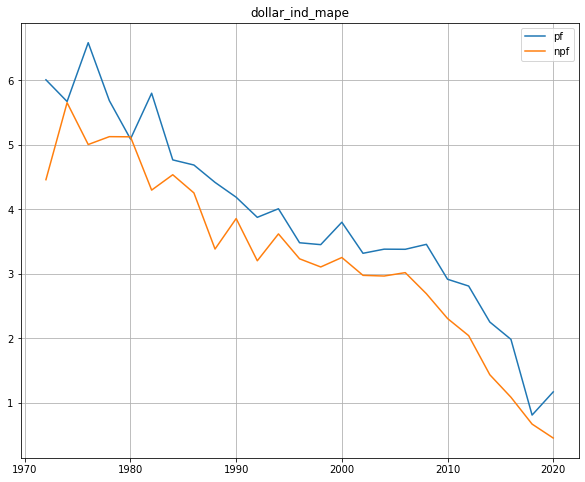

In [620]:
df = dollar_ind_various_term_mape

plt.figure(figsize=(10,8))
plt.title("dollar_ind_mape")
plt.plot(df["start_date_to_use"],df["pf_mape"] ,label= "pf")
plt.plot(df["start_date_to_use"],df["npf_mape"], label= "npf")
plt.grid()
plt.legend();

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]

  x[:, None]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]

  x = x[:, np.newaxis]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead

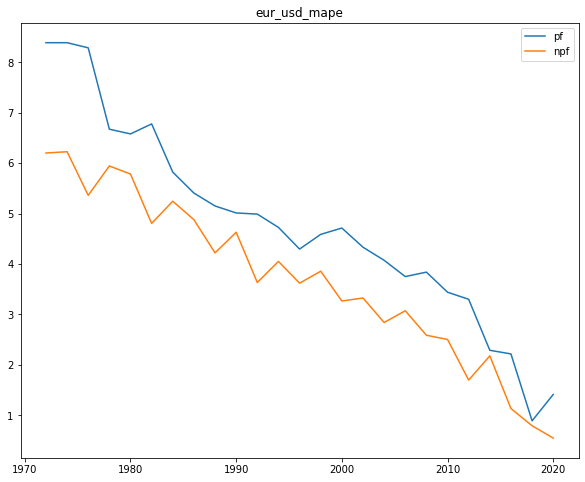

In [632]:
df = eur_usd_various_term_mape

plt.figure(figsize=(10,8))
plt.title("eur_usd_mape")
plt.plot(df["start_date_to_use"],df["pf_mape"] ,label= "pf")
plt.plot(df["start_date_to_use"],df["npf_mape"], label= "npf")
plt.legend();

In [ ]:
↑どちらも2020以降の短期間でのnpfが最も誤差が低そう


期間を短くするほど、当てはまりが良い、という結果
yhatとactualをプロットしたものを見ても、最後の３ヶ月の変動についていってるのは2020〜で予測したもののみ


# 週次を使って分析

Text(0.5, 0, 'Day')

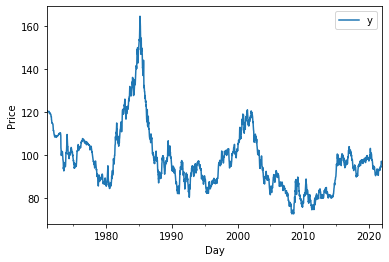

In [728]:

#df = eur_usd_weekly_1975
df = dollar_ind_weekly_1975
target_price = "高値"



df1 = df.loc[: ,["高値","date"]].rename(columns={"高値":"y" , "date":"ds"})

#前処理
#df["date"] = pd.to_datetime(df.index, format='%Y-%m-%d')
df = df.sort_values(by = "date")
df1 = df.loc[: ,[target_price,"date"]].rename(columns={target_price:"y" , "date":"ds"})#高値で予測

#変化を描画し、周期性がありそうか確認
df1.set_index("ds").plot()
#plt.title('Page Views of Peyton Manning') #グラフタイトル
plt.ylabel('Price')             #タテ軸のラベル
plt.xlabel('Day')                          #ヨコ軸のラベル



# Prophet 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]

  x[:, None]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]

  y = y[:, np.newax

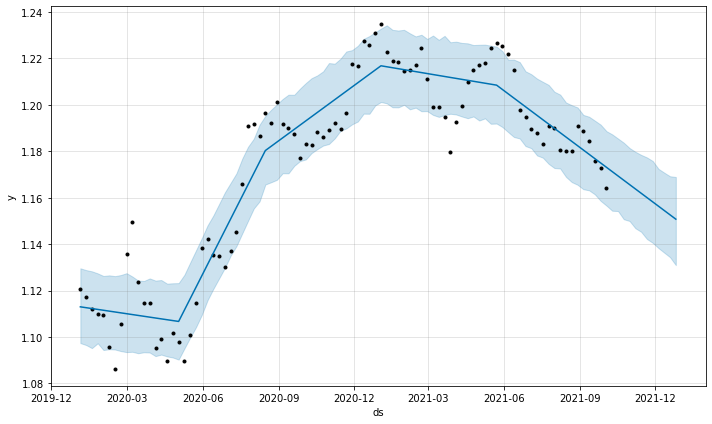

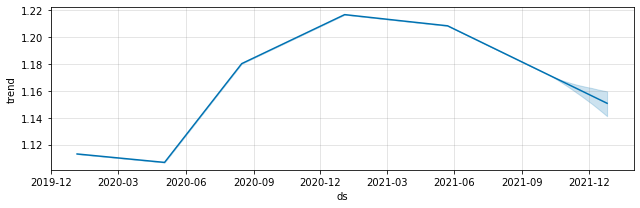

In [852]:
start_date_to_use = "2020-01-01"
test_length = 12

df = eur_usd_weekly_1975
#df = dollar_ind_weekly_1975



df1 = df.loc[: ,["高値","date"]].rename(columns={"高値":"y" , "date":"ds"})
#利用期間
df1 = df1[df1["ds"] >= dt.strptime(start_date_to_use, "%Y-%m-%d")]

# 学習データとテストデータの分割
df1_train = df1.iloc[:-test_length]
df1_test = df1.iloc[-test_length:]


# Prophet 予測モデル構築
df1_prophet_model = Prophet(seasonality_mode='multiplicative')
df1_prophet_model.fit(df1_train)

# Prophet 予測モデルの精度検証用データの生成
df1_future = df1_prophet_model.make_future_dataframe(periods=test_length, freq="W")
#日付が１日ズレるので修正する
#for index in df1_future.index[-test_length:]:
#    df1_future.loc[index ] = df1_future.loc[index ] + datetime.timedelta(days=1)
df1_pred = df1_prophet_model.predict(df1_future)
df1_pred["y"] = list(df1["y"])

# Prophet 予測モデルの予測結果（学習データ期間＋テストデータ期間）
df1_pred_plot = df1_prophet_model.plot(df1_pred)         #予想値（点は学習データの実測値）
df1_pmpc = df1_prophet_model.plot_components(df1_pred)   #モデルの要素分解

# テストデータに予測値を結合
df1_test = pd.merge( df1_pred.loc[: , ["ds", "yhat"]], df1_test, on = "ds" , how = "inner")
df1_test = df1_test.rename(columns = {"yhat":'Prophet Predict'})


MAE:
0.01261860933529707
MAPE:
1.106577696541679


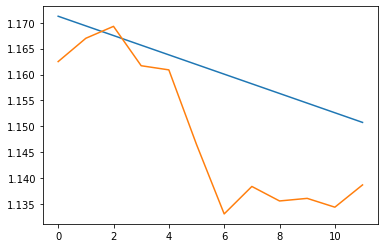

In [853]:
# Prophet 予測モデルの精度検証（テストデータ期間）
print('MAE:')
print(mean_absolute_error(df1_test['y'], df1_test['Prophet Predict'])) 
print('MAPE:')
print(mean(abs(df1_test['y'] - df1_test['Prophet Predict'])/df1_test['y']) *100)

for col in ["Prophet Predict","y"]:
    plt.plot(df1_test[col])

# NeuralProphet

In [854]:
# NeuralProphet 予測モデル構築
df1_nprophet_model = NeuralProphet(seasonality_mode='multiplicative')# yearly_seasonality=True
df1_nprophet_model_result = df1_nprophet_model.fit(df1_train, freq="W")

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 326
INFO:NP.config:Auto-set epochs to 326


  0%|          | 0/200 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.06E-02, min: 2.35E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.06E-02, min: 2.35E+00


  0%|          | 0/200 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.54E-02, min: 2.90E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.54E-02, min: 2.90E+00


  0%|          | 0/200 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.06E-02, min: 6.67E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.06E-02, min: 6.67E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.50E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 4.50E-02
Epoch[326/326]: 100%|██████████| 326/326 [00:10<00:00, 30.36it/s, SmoothL1Loss=0.00397, MAE=0.0102, RMSE=0.0123, RegLoss=0]


WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]

  x[:, None]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]

  y = y[:, np.newaxis]



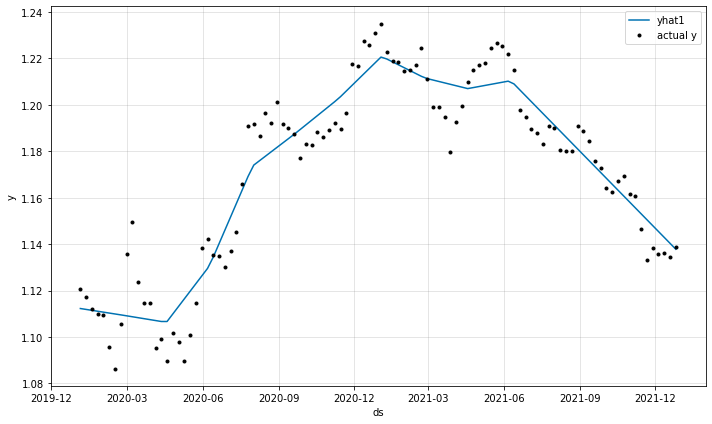

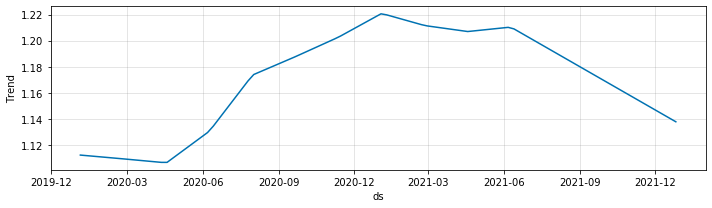

In [855]:
# NeuralProphet 予測モデルの精度検証用データの生成
df1_future = df1_nprophet_model.make_future_dataframe(df1_train, 
                                                      periods = test_length, 
                                                      n_historic_predictions=len(df1_train))
#日付が１日ズレるので修正する
#for index in df1_future.index[-test_length:]:
#    df1_future.loc[index ] = df1_future.loc[index ] + datetime.timedelta(days=1)

df1_pred = df1_nprophet_model.predict(df1_future)
df1_pred["y"] = list(df1["y"])

# NeuralProphet 予測モデルの予測結果（学習データ期間＋テストデータ期間）
df1_pred_plot = df1_nprophet_model.plot(df1_pred)         #予想値（点は学習データの実測値）
df1_pmpc = df1_nprophet_model.plot_components(df1_pred)   #モデルの要素分解

# テストデータに予測値を結合
df1_test = pd.merge( df1_pred.loc[: , ["ds", "yhat1"]], df1_test, on = "ds" , how = "inner")
df1_test = df1_test.rename(columns = {"yhat1":'NeuralProphet Predict'})

MAE(Prophet):
0.01261860933529707
MAE(NeuralProphet):
0.006794006506601946
----------------------------
MAPE(Prophet):
1.106577696541679
MAPE(NeuralProphet):
0.5933849284522498


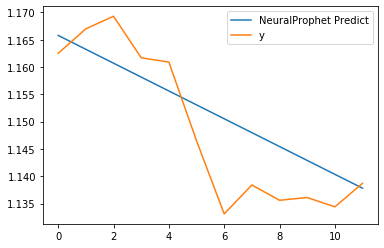

In [856]:


# NeuralProphet 予測モデルの精度検証（テストデータ期間）
print('MAE(Prophet):')
print(mean_absolute_error(df1_test['y'], df1_test['Prophet Predict'])) 
print('MAE(NeuralProphet):')
print(mean_absolute_error(df1_test['y'], df1_test['NeuralProphet Predict'])) 
print('----------------------------')
print('MAPE(Prophet):')
print(mean(abs(df1_test['y'] - df1_test['Prophet Predict'])/df1_test['y']) *100)
print('MAPE(NeuralProphet):')
print(mean(abs(df1_test['y'] - df1_test['NeuralProphet Predict'])/df1_test['y']) *100)
for col in ["NeuralProphet Predict","y"]:
    plt.plot(df1_test[col] , label = col)
plt.legend()

In [825]:
#実際に３ヶ月先までの予測をしてみる

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]

  x[:, None]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]

  y = y[:, np.newaxis]



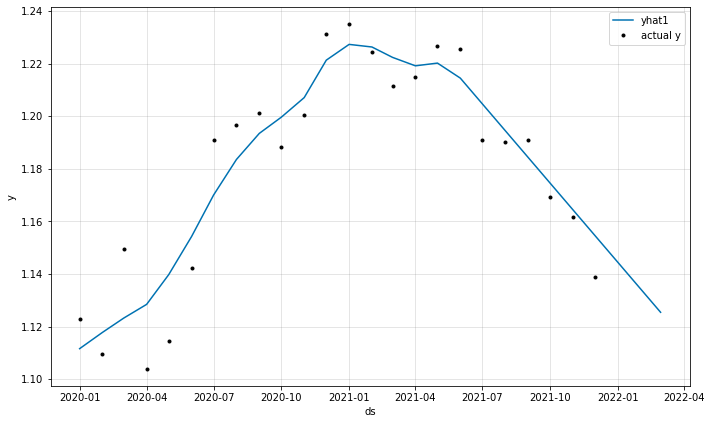

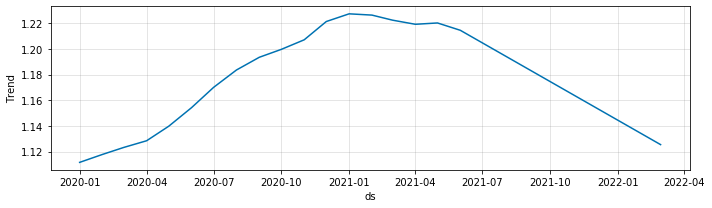

In [885]:


# NeuralProphet inputデータの生成
real_future_3month = df1_nprophet_model.make_future_dataframe(df1, 
                                                      periods = test_length, 
                                                      n_historic_predictions=len(df1))
#日付が１日ズレるので修正する
#for index in df1_future.index[-test_length:]:
#    df1_future.loc[index ] = df1_future.loc[index ] + datetime.timedelta(days=1)

real_future_3month_pred = df1_nprophet_model.predict(real_future_3month)
#real_future_3month_pred["y"] = list(df1["y"])

# NeuralProphet 予測モデルの予測結果（学習データ期間＋テストデータ期間）
real_future_3month_pred_pred_plot = df1_nprophet_model.plot(real_future_3month_pred)         #予想値（点は学習データの実測値）
real_future_3month_pred_pmpc = df1_nprophet_model.plot_components(real_future_3month_pred)   #モデルの要素分解



In [ ]:
#探索・・・最もフィットする期間を求める関数

In [751]:
#予測した期間の予測値のdfを返す関数

def get_predict_df_weekly(df, start_date_to_use ,test_length):
    df1 = df.loc[: ,["高値","date"]].rename(columns={"高値":"y" , "date":"ds"})
    #利用期間
    df1 = df1[df1["ds"] >= dt.strptime(start_date_to_use, "%Y-%m-%d")]

    # 学習データとテストデータの分割
    df1_train = df1.iloc[:-test_length]
    df1_test = df1.iloc[-test_length:]


    # Prophet 予測モデル構築
    df1_prophet_model = Prophet(seasonality_mode='multiplicative')
    df1_prophet_model.fit(df1_train)

    # Prophet 予測モデルの精度検証用データの生成
    df1_future = df1_prophet_model.make_future_dataframe(periods=test_length, freq='M')
    #日付が１日ズレるので修正する
    #for index in df1_future.index[-test_length:]:
    #    df1_future.loc[index ] = df1_future.loc[index ] + datetime.timedelta(days=1)
    df1_pred = df1_prophet_model.predict(df1_future)
    df1_pred["y"] = list(df1["y"])

    # Prophet 予測モデルの予測結果（学習データ期間＋テストデータ期間）
    #df1_pred_plot = df1_prophet_model.plot(df1_pred)         #予想値（点は学習データの実測値）
    #df1_pmpc = df1_prophet_model.plot_components(df1_pred)   #モデルの要素分解

    # テストデータに予測値を結合
    df1_test = pd.merge( df1_pred.loc[: , ["ds", "yhat"]], df1_test, on = "ds" , how = "inner")
    df1_test = df1_test.rename(columns = {"yhat":'Prophet Predict'})
    
    #全期間の予測結果をpfとnpf両方出力するためのdf
    pred_all_df = df1_pred.loc[: , ["ds","y","yhat"]].copy()
    pred_all_df = pred_all_df.rename(columns = {"yhat":'Prophet Predict'})

    # NeuralProphet 予測モデル構築
    df1_nprophet_model = NeuralProphet(seasonality_mode='multiplicative')
    df1_nprophet_model_result = df1_nprophet_model.fit(df1_train, freq="M")

    # NeuralProphet 予測モデルの精度検証用データの生成
    df1_future = df1_nprophet_model.make_future_dataframe(df1_train, 
                                                          periods = test_length, 
                                                          n_historic_predictions=len(df1_train))
    #日付が１日ズレるので修正する
    #for index in df1_future.index[-test_length:]:
    #    df1_future.loc[index ] = df1_future.loc[index ] + datetime.timedelta(days=1)

    df1_pred = df1_nprophet_model.predict(df1_future)
    df1_pred["y"] = list(df1["y"])

    # NeuralProphet 予測モデルの予測結果（学習データ期間＋テストデータ期間）
    #df1_pred_plot = df1_nprophet_model.plot(df1_pred)         #予想値（点は学習データの実測値）
    #df1_pmpc = df1_nprophet_model.plot_components(df1_pred)   #モデルの要素分解

    # テストデータに予測値を結合
    df1_test = pd.merge( df1_pred.loc[: , ["ds", "yhat1"]], df1_test, on = "ds" , how = "inner")
    df1_test = df1_test.rename(columns = {"yhat1":'NeuralProphet Predict'})
    
    #全期間の予測結果をpfとnpf両方出力するためのdf
    pred_all_df = pd.merge(pred_all_df, df1_pred.loc[: , ["ds","yhat1"]].copy(), on = "ds")
    pred_all_df = pred_all_df.rename(columns = {"yhat1":'NeuralProphet Predict'})
    
    return df1_test ,pred_all_df

In [752]:

def get_all_predict_df_weekly(df, start_date_overall ,test_length ):
    all_predict_df = pd.DataFrame()
    for add_years in range(0,50):
        start_date_to_use = dt.strptime(start_date_overall, "%Y-%m-%d")+ relativedelta(years=add_years) 
        df_test ,df_pred = get_predict_df_weekly(df, start_date_to_use.strftime('%Y-%m-%d') ,test_length)
        df_pred["start_date_to_use"] = start_date_to_use
        all_predict_df = pd.concat([all_predict_df, df_pred], axis=0)
    return all_predict_df

In [753]:
start_date_overall = "1972-01-01"
test_length = 12

#df = eur_usd_weekly_1975
#df = dollar_ind_weekly_1975


eur_usd_various_term_predict_weekly = get_all_predict_df_weekly(eur_usd_weekly_1975, start_date_overall ,test_length )
dollar_ind_various_term_predict_weekly = get_all_predict_df_weekly(dollar_ind_weekly_1975, start_date_overall ,test_length )




INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 145
INFO:NP.config:Auto-set epochs to 145


  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.22E-02, min: 4.13E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.22E-02, min: 4.13E-01


  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.44E+00, min: 4.82E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.44E+00, min: 4.82E-01


  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.45E-02, min: 3.54E-01
INFO:NP.utils_torch:lr-range-test results: steep: 6.45E-02, min: 3.54E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.72E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.72E-01
Epoch[145/145]: 100%|██████████| 145/145 [00:18<00:00,  7.81it/s, SmoothL1Loss=0.00661, MAE=0.0733, RMSE=0.0902, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.97E-02, min: 3.33E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.97E-02, min: 3.33E+00


  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.45E-02, min: 2.44E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.45E-02, min: 2.44E+00


  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.45E-02, min: 3.08E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.45E-02, min: 3.08E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.29E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 6.29E-02
Epoch[145/145]: 100%|██████████| 145/145 [00:19<00:00,  7.62it/s, SmoothL1Loss=0.00661, MAE=0.0733, RMSE=0.0902, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.97E-02, min: 1.66E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.97E-02, min: 1.66E+00


  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.97E-02, min: 1.66E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.97E-02, min: 1.66E+00


  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.97E-02, min: 2.85E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.97E-02, min: 2.85E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.97E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.97E-02
Epoch[145/145]: 100%|██████████| 145/145 [00:17<00:00,  8.23it/s, SmoothL1Loss=0.00661, MAE=0.0733, RMSE=0.0905, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.98E-02, min: 1.32E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.98E-02, min: 1.32E+00


  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.79E+00, min: 1.94E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.79E+00, min: 1.94E+00


  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.98E-02, min: 1.42E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.98E-02, min: 1.42E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.90E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.90E-01
Epoch[145/145]: 100%|██████████| 145/145 [00:17<00:00,  8.27it/s, SmoothL1Loss=0.00661, MAE=0.0733, RMSE=0.0903, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.94E-02, min: 2.23E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.94E-02, min: 2.23E+00


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.26E-02, min: 1.51E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.26E-02, min: 1.51E+00


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.94E-02, min: 2.60E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.94E-02, min: 2.60E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.04E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 4.04E-02
Epoch[145/145]: 100%|██████████| 145/145 [00:16<00:00,  8.54it/s, SmoothL1Loss=0.00483, MAE=0.0625, RMSE=0.0773, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.44E-02, min: 6.96E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.44E-02, min: 6.96E-01


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-02, min: 3.46E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.23E-02, min: 3.46E-01


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.44E-02, min: 6.44E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.44E-02, min: 6.44E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.36E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 1.36E-02
Epoch[146/146]: 100%|██████████| 146/146 [00:16<00:00,  8.66it/s, SmoothL1Loss=0.00494, MAE=0.0656, RMSE=0.0786, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.37E-02, min: 4.04E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.37E-02, min: 4.04E-01


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.04E+00, min: 5.10E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.04E+00, min: 5.10E-01


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.37E-02, min: 3.46E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.37E-02, min: 3.46E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.51E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.51E-01
Epoch[147/147]: 100%|██████████| 147/147 [00:16<00:00,  8.78it/s, SmoothL1Loss=0.00565, MAE=0.0695, RMSE=0.084, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/267 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.39E-02, min: 4.63E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.39E-02, min: 4.63E-01


  0%|          | 0/267 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.29E-02, min: 2.48E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.29E-02, min: 2.48E-01


  0%|          | 0/267 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.50E-02, min: 2.12E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.50E-02, min: 2.12E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.39E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 1.39E-02
Epoch[148/148]: 100%|██████████| 148/148 [00:16<00:00,  9.00it/s, SmoothL1Loss=0.00579, MAE=0.0702, RMSE=0.0849, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/267 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-01, min: 2.03E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.23E-01, min: 2.03E+00


  0%|          | 0/267 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-01, min: 2.03E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.23E-01, min: 2.03E+00


  0%|          | 0/267 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-01, min: 2.20E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.23E-01, min: 2.20E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.23E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.23E-01
Epoch[149/149]: 100%|██████████| 149/149 [00:16<00:00,  9.15it/s, SmoothL1Loss=0.00501, MAE=0.0642, RMSE=0.0784, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/266 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.72E-02, min: 3.88E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.72E-02, min: 3.88E-01


  0%|          | 0/266 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.72E-02, min: 3.32E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.72E-02, min: 3.32E-01


  0%|          | 0/266 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.94E-02, min: 3.32E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.94E-02, min: 3.32E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.79E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 2.79E-02
Epoch[150/150]: 100%|██████████| 150/150 [00:15<00:00,  9.38it/s, SmoothL1Loss=0.00419, MAE=0.0577, RMSE=0.0702, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/265 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.64E-02, min: 2.31E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.64E-02, min: 2.31E+00


  0%|          | 0/265 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.52E-02, min: 2.14E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.52E-02, min: 2.14E+00


  0%|          | 0/265 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.64E-02, min: 2.14E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.64E-02, min: 2.14E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.60E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 1.60E-02
Epoch[151/151]: 100%|██████████| 151/151 [00:15<00:00,  9.70it/s, SmoothL1Loss=0.00409, MAE=0.0572, RMSE=0.0695, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/265 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.00E+00, min: 4.56E-02
INFO:NP.utils_torch:lr-range-test results: steep: 4.00E+00, min: 4.56E-02


  0%|          | 0/265 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.85E-02, min: 5.77E-02
INFO:NP.utils_torch:lr-range-test results: steep: 2.85E-02, min: 5.77E-02


  0%|          | 0/265 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.43E-02, min: 3.25E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.43E-02, min: 3.25E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.41E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.41E-01
Epoch[152/152]: 100%|██████████| 152/152 [00:15<00:00,  9.79it/s, SmoothL1Loss=0.00491, MAE=0.0619, RMSE=0.0762, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/264 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.61E-02, min: 8.85E-01
INFO:NP.utils_torch:lr-range-test results: steep: 5.61E-02, min: 8.85E-01


  0%|          | 0/264 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.61E-02, min: 5.86E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.61E-02, min: 5.86E+00


  0%|          | 0/264 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.61E-02, min: 9.57E-01
INFO:NP.utils_torch:lr-range-test results: steep: 5.61E-02, min: 9.57E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.61E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.61E-02
Epoch[153/153]: 100%|██████████| 153/153 [00:15<00:00, 10.15it/s, SmoothL1Loss=0.0046, MAE=0.0611, RMSE=0.0741, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/264 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.72E-01, min: 4.79E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.72E-01, min: 4.79E-02


  0%|          | 0/264 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.44E-01, min: 2.46E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.44E-01, min: 2.46E+00


  0%|          | 0/264 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.44E-01, min: 6.86E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.44E-01, min: 6.86E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.53E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 3.53E-01
Epoch[154/154]: 100%|██████████| 154/154 [00:14<00:00, 10.46it/s, SmoothL1Loss=0.00437, MAE=0.0601, RMSE=0.0724, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/263 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.45E-02, min: 6.85E-01
INFO:NP.utils_torch:lr-range-test results: steep: 5.45E-02, min: 6.85E-01


  0%|          | 0/263 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.91E-02, min: 6.33E-01
INFO:NP.utils_torch:lr-range-test results: steep: 6.91E-02, min: 6.33E-01


  0%|          | 0/263 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.45E-02, min: 1.92E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.45E-02, min: 1.92E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.90E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.90E-02
Epoch[155/155]: 100%|██████████| 155/155 [00:14<00:00, 10.47it/s, SmoothL1Loss=0.00727, MAE=0.0592, RMSE=0.0715, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/263 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.10E+00, min: 4.23E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.10E+00, min: 4.23E+00


  0%|          | 0/263 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.65E-01, min: 2.24E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.65E-01, min: 2.24E+00


  0%|          | 0/263 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.65E-01, min: 3.33E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.65E-01, min: 3.33E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.11E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 3.11E-01
Epoch[156/156]: 100%|██████████| 156/156 [00:14<00:00, 10.96it/s, SmoothL1Loss=0.0063, MAE=0.0534, RMSE=0.0667, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/262 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.29E-01, min: 2.81E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.29E-01, min: 2.81E-02


  0%|          | 0/262 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.29E-01, min: 2.81E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.29E-01, min: 2.81E-02


  0%|          | 0/262 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.56E-01, min: 3.04E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.56E-01, min: 3.04E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.38E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 3.38E-01
Epoch[157/157]: 100%|██████████| 157/157 [00:14<00:00, 11.13it/s, SmoothL1Loss=0.00592, MAE=0.0513, RMSE=0.0647, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/261 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.08E-02, min: 2.01E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.08E-02, min: 2.01E+00


  0%|          | 0/261 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.04E-02, min: 7.14E-01
INFO:NP.utils_torch:lr-range-test results: steep: 6.04E-02, min: 7.14E-01


  0%|          | 0/261 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.08E-02, min: 2.36E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.08E-02, min: 2.36E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.71E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 6.71E-02
Epoch[158/158]: 100%|██████████| 158/158 [00:13<00:00, 11.41it/s, SmoothL1Loss=0.00622, MAE=0.0547, RMSE=0.0665, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/261 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.56E+00, min: 7.67E-02
INFO:NP.utils_torch:lr-range-test results: steep: 2.56E+00, min: 7.67E-02


  0%|          | 0/261 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.56E+00, min: 1.14E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.56E+00, min: 1.14E-01


  0%|          | 0/261 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.82E-01, min: 1.05E-01
INFO:NP.utils_torch:lr-range-test results: steep: 9.82E-01, min: 1.05E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.86E+00
INFO:NP.forecaster:lr-range-test selected learning rate: 1.86E+00
Epoch[159/159]: 100%|██████████| 159/159 [00:13<00:00, 11.85it/s, SmoothL1Loss=0.00611, MAE=0.0553, RMSE=0.0662, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/260 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.65E-01, min: 1.11E-01
INFO:NP.utils_torch:lr-range-test results: steep: 9.65E-01, min: 1.11E-01


  0%|          | 0/260 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.91E-01, min: 1.31E-01
INFO:NP.utils_torch:lr-range-test results: steep: 8.91E-01, min: 1.31E-01


  0%|          | 0/260 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.78E+00, min: 1.21E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.78E+00, min: 1.21E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.60E+00
INFO:NP.forecaster:lr-range-test selected learning rate: 1.60E+00
Epoch[161/161]: 100%|██████████| 161/161 [00:13<00:00, 12.09it/s, SmoothL1Loss=0.00487, MAE=0.0477, RMSE=0.0593, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/259 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.85E-02, min: 4.73E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.85E-02, min: 4.73E+00


  0%|          | 0/259 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.85E-02, min: 2.12E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.85E-02, min: 2.12E+00


  0%|          | 0/259 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.85E-02, min: 5.12E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.85E-02, min: 5.12E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.85E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 4.85E-02
Epoch[162/162]: 100%|██████████| 162/162 [00:13<00:00, 12.39it/s, SmoothL1Loss=0.00475, MAE=0.0457, RMSE=0.0585, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/258 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.86E-01, min: 2.24E-07
INFO:NP.utils_torch:lr-range-test results: steep: 1.86E-01, min: 2.24E-07


  0%|          | 0/258 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.86E-01, min: 1.92E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.86E-01, min: 1.92E+00


  0%|          | 0/258 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.97E+00, min: 6.74E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.97E+00, min: 6.74E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.15E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 5.15E-01
Epoch[163/163]: 100%|██████████| 163/163 [00:12<00:00, 12.94it/s, SmoothL1Loss=0.00488, MAE=0.0474, RMSE=0.0591, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/258 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.71E-02, min: 1.64E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.71E-02, min: 1.64E+00


  0%|          | 0/258 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.01E-02, min: 1.29E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.01E-02, min: 1.29E+00


  0%|          | 0/258 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.71E-02, min: 1.64E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.71E-02, min: 1.64E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.46E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 4.46E-02
Epoch[165/165]: 100%|██████████| 165/165 [00:12<00:00, 13.29it/s, SmoothL1Loss=0.00512, MAE=0.0497, RMSE=0.0612, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.13E+00, min: 3.43E-03
INFO:NP.utils_torch:lr-range-test results: steep: 8.13E+00, min: 3.43E-03


  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.46E-01, min: 4.37E-03
INFO:NP.utils_torch:lr-range-test results: steep: 3.46E-01, min: 4.37E-03


  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.46E-01, min: 4.03E-03
INFO:NP.utils_torch:lr-range-test results: steep: 3.46E-01, min: 4.03E-03
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.91E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 9.91E-01
Epoch[166/166]: 100%|██████████| 166/166 [00:12<00:00, 13.72it/s, SmoothL1Loss=0.00389, MAE=0.0425, RMSE=0.0534, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/256 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.63E-01, min: 2.02E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.63E-01, min: 2.02E+00


  0%|          | 0/256 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.63E-01, min: 1.86E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.63E-01, min: 1.86E+00


  0%|          | 0/256 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.98E-01, min: 1.58E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.98E-01, min: 1.58E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.03E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 7.03E-01
Epoch[168/168]: 100%|██████████| 168/168 [00:11<00:00, 14.27it/s, SmoothL1Loss=0.00437, MAE=0.0451, RMSE=0.0568, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/255 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.90E-01, min: 1.56E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.90E-01, min: 1.56E+00


  0%|          | 0/255 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.59E-01, min: 1.56E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.59E-01, min: 1.56E+00


  0%|          | 0/255 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.39E+00, min: 2.76E+00
INFO:NP.utils_torch:lr-range-test results: steep: 9.39E+00, min: 2.76E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.09E+00
INFO:NP.forecaster:lr-range-test selected learning rate: 1.09E+00
Epoch[169/169]: 100%|██████████| 169/169 [00:11<00:00, 14.67it/s, SmoothL1Loss=0.00476, MAE=0.0475, RMSE=0.0601, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/254 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.15E-01, min: 3.54E-02
INFO:NP.utils_torch:lr-range-test results: steep: 2.15E-01, min: 3.54E-02


  0%|          | 0/254 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.33E-01, min: 4.17E-02
INFO:NP.utils_torch:lr-range-test results: steep: 2.33E-01, min: 4.17E-02


  0%|          | 0/254 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.22E-02, min: 3.54E-02
INFO:NP.utils_torch:lr-range-test results: steep: 1.22E-02, min: 3.54E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.49E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 8.49E-02
Epoch[171/171]: 100%|██████████| 171/171 [00:11<00:00, 14.88it/s, SmoothL1Loss=0.00399, MAE=0.0443, RMSE=0.0555, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/253 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.73E-01, min: 3.43E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.73E-01, min: 3.43E-02


  0%|          | 0/253 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.05E-01, min: 3.43E-02
INFO:NP.utils_torch:lr-range-test results: steep: 4.05E-01, min: 3.43E-02


  0%|          | 0/253 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.73E-01, min: 3.43E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.73E-01, min: 3.43E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.83E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 3.83E-01
Epoch[173/173]: 100%|██████████| 173/173 [00:11<00:00, 15.56it/s, SmoothL1Loss=0.00314, MAE=0.0392, RMSE=0.0492, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.39E-02, min: 2.43E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.39E-02, min: 2.43E+00


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.60E-02, min: 3.12E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.60E-02, min: 3.12E+00


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.60E-02, min: 2.24E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.60E-02, min: 2.24E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.53E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 2.53E-02
Epoch[175/175]: 100%|██████████| 175/175 [00:10<00:00, 16.33it/s, SmoothL1Loss=0.00387, MAE=0.0431, RMSE=0.0547, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/251 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.96E-02, min: 4.21E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.96E-02, min: 4.21E-01


  0%|          | 0/251 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.96E-02, min: 4.57E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.96E-02, min: 4.57E-01


  0%|          | 0/251 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.29E-02, min: 8.87E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.29E-02, min: 8.87E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.71E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 1.71E-02
Epoch[177/177]: 100%|██████████| 177/177 [00:10<00:00, 17.13it/s, SmoothL1Loss=0.00401, MAE=0.0447, RMSE=0.0553, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/250 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.68E-02, min: 3.89E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.68E-02, min: 3.89E+00


  0%|          | 0/250 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.00E-02, min: 3.58E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.00E-02, min: 3.58E+00


  0%|          | 0/250 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.00E-02, min: 3.30E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.00E-02, min: 3.30E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.89E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 3.89E-02
Epoch[179/179]: 100%|██████████| 179/179 [00:10<00:00, 17.57it/s, SmoothL1Loss=0.00415, MAE=0.0444, RMSE=0.0552, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/249 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.42E-02, min: 2.53E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.42E-02, min: 2.53E+00


  0%|          | 0/249 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.42E-02, min: 2.14E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.42E-02, min: 2.14E+00


  0%|          | 0/249 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.98E-02, min: 3.25E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.98E-02, min: 3.25E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.27E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.27E-02
Epoch[181/181]: 100%|██████████| 181/181 [00:16<00:00, 10.77it/s, SmoothL1Loss=0.00806, MAE=0.044, RMSE=0.0537, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/248 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.59E-01, min: 2.31E-07
INFO:NP.utils_torch:lr-range-test results: steep: 2.59E-01, min: 2.31E-07


  0%|          | 0/248 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.81E-01, min: 2.31E-07
INFO:NP.utils_torch:lr-range-test results: steep: 2.81E-01, min: 2.31E-07


  0%|          | 0/248 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.59E-01, min: 2.31E-07
INFO:NP.utils_torch:lr-range-test results: steep: 2.59E-01, min: 2.31E-07
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.66E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 2.66E-01
Epoch[184/184]: 100%|██████████| 184/184 [00:37<00:00,  4.94it/s, SmoothL1Loss=0.00647, MAE=0.0375, RMSE=0.0482, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/247 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.96E-01, min: 2.32E-07
INFO:NP.utils_torch:lr-range-test results: steep: 1.96E-01, min: 2.32E-07


  0%|          | 0/247 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.96E-01, min: 2.32E-07
INFO:NP.utils_torch:lr-range-test results: steep: 1.96E-01, min: 2.32E-07


  0%|          | 0/247 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.80E-01, min: 2.32E-07
INFO:NP.utils_torch:lr-range-test results: steep: 1.80E-01, min: 2.32E-07
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.91E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.91E-01
Epoch[187/187]: 100%|██████████| 187/187 [00:15<00:00, 11.84it/s, SmoothL1Loss=0.0076, MAE=0.0432, RMSE=0.0527, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/246 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.48E-01, min: 2.33E-07
INFO:NP.utils_torch:lr-range-test results: steep: 1.48E-01, min: 2.33E-07


  0%|          | 0/246 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.61E-01, min: 2.33E-07
INFO:NP.utils_torch:lr-range-test results: steep: 1.61E-01, min: 2.33E-07


  0%|          | 0/246 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.13E+00, min: 2.33E-07
INFO:NP.utils_torch:lr-range-test results: steep: 6.13E+00, min: 2.33E-07
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.28E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 5.28E-01
Epoch[189/189]: 100%|██████████| 189/189 [00:14<00:00, 12.78it/s, SmoothL1Loss=0.00742, MAE=0.0414, RMSE=0.0525, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/244 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.11E-01, min: 3.30E-03
INFO:NP.utils_torch:lr-range-test results: steep: 7.11E-01, min: 3.30E-03


  0%|          | 0/244 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.18E-01, min: 3.59E-03
INFO:NP.utils_torch:lr-range-test results: steep: 9.18E-01, min: 3.59E-03


  0%|          | 0/244 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.19E+00, min: 3.59E-03
INFO:NP.utils_torch:lr-range-test results: steep: 1.19E+00, min: 3.59E-03
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.18E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 9.18E-01
Epoch[193/193]: 100%|██████████| 193/193 [00:14<00:00, 13.45it/s, SmoothL1Loss=0.00542, MAE=0.0345, RMSE=0.045, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/243 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.52E-02, min: 3.25E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.52E-02, min: 3.25E+00


  0%|          | 0/243 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.52E-02, min: 4.99E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.52E-02, min: 4.99E+00


  0%|          | 0/243 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.19E-02, min: 2.99E+00
INFO:NP.utils_torch:lr-range-test results: steep: 8.19E-02, min: 2.99E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.73E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 7.73E-02
Epoch[196/196]: 100%|██████████| 196/196 [00:13<00:00, 14.42it/s, SmoothL1Loss=0.00519, MAE=0.0345, RMSE=0.0442, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/241 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.55E-02, min: 1.73E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.55E-02, min: 1.73E+00


  0%|          | 0/241 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.55E-02, min: 1.22E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.55E-02, min: 1.22E+00


  0%|          | 0/241 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.55E-02, min: 1.03E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.55E-02, min: 1.03E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.55E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 3.55E-02
Epoch[200/200]: 100%|██████████| 200/200 [00:13<00:00, 15.17it/s, SmoothL1Loss=0.0052, MAE=0.0306, RMSE=0.0394, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/239 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.25E-01, min: 5.54E-04
INFO:NP.utils_torch:lr-range-test results: steep: 2.25E-01, min: 5.54E-04


  0%|          | 0/239 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.07E-01, min: 3.01E-04
INFO:NP.utils_torch:lr-range-test results: steep: 2.07E-01, min: 3.01E-04


  0%|          | 0/239 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.07E-01, min: 2.32E-04
INFO:NP.utils_torch:lr-range-test results: steep: 2.07E-01, min: 2.32E-04
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.13E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 2.13E-01
Epoch[204/204]: 100%|██████████| 204/204 [00:12<00:00, 16.23it/s, SmoothL1Loss=0.00567, MAE=0.031, RMSE=0.0384, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.26E-02, min: 2.10E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.26E-02, min: 2.10E+00


  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.26E-02, min: 2.50E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.26E-02, min: 2.50E+00


  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.26E-02, min: 3.88E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.26E-02, min: 3.88E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.26E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 6.26E-02
Epoch[208/208]: 100%|██████████| 208/208 [00:11<00:00, 17.40it/s, SmoothL1Loss=0.00275, MAE=0.0206, RMSE=0.0258, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/235 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.02E-02, min: 2.03E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.02E-02, min: 2.03E+00


  0%|          | 0/235 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.67E-02, min: 1.43E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.67E-02, min: 1.43E+00


  0%|          | 0/235 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.02E-02, min: 3.78E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.02E-02, min: 3.78E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.23E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 7.23E-02
Epoch[213/213]: 100%|██████████| 213/213 [00:11<00:00, 19.14it/s, SmoothL1Loss=0.00289, MAE=0.0196, RMSE=0.0239, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/233 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.22E-02, min: 1.96E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.22E-02, min: 1.96E+00


  0%|          | 0/233 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.86E-02, min: 3.07E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.86E-02, min: 3.07E+00


  0%|          | 0/233 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.86E-02, min: 1.96E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.86E-02, min: 1.96E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.97E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 3.97E-02
Epoch[219/219]: 100%|██████████| 219/219 [00:10<00:00, 20.93it/s, SmoothL1Loss=0.00223, MAE=0.0172, RMSE=0.0212, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/230 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.61E+00, min: 1.08E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.61E+00, min: 1.08E+00


  0%|          | 0/230 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.85E-02, min: 1.19E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.85E-02, min: 1.19E+00


  0%|          | 0/230 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.51E+00, min: 1.30E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.51E+00, min: 1.30E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.69E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 6.69E-01
Epoch[226/226]: 100%|██████████| 226/226 [00:09<00:00, 22.88it/s, SmoothL1Loss=0.00218, MAE=0.0166, RMSE=0.0205, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/227 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.63E-01, min: 4.08E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.63E-01, min: 4.08E-01


  0%|          | 0/227 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.49E-01, min: 4.47E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.49E-01, min: 4.47E-01


  0%|          | 0/227 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.36E-01, min: 2.83E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.36E-01, min: 2.83E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.49E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.49E-01
Epoch[234/234]: 100%|██████████| 234/234 [00:09<00:00, 25.26it/s, SmoothL1Loss=0.00589, MAE=0.0154, RMSE=0.019, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/224 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.40E-02, min: 2.93E+00
INFO:NP.utils_torch:lr-range-test results: steep: 9.40E-02, min: 2.93E+00


  0%|          | 0/224 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.40E-02, min: 2.93E+00
INFO:NP.utils_torch:lr-range-test results: steep: 9.40E-02, min: 2.93E+00


  0%|          | 0/224 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.40E-02, min: 5.11E+00
INFO:NP.utils_torch:lr-range-test results: steep: 9.40E-02, min: 5.11E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.40E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 9.40E-02
Epoch[243/243]: 100%|██████████| 243/243 [00:07<00:00, 30.57it/s, SmoothL1Loss=0.00399, MAE=0.013, RMSE=0.0161, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/220 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.21E-02, min: 1.21E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.21E-02, min: 1.21E-01


  0%|          | 0/220 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.21E-02, min: 1.21E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.21E-02, min: 1.21E-01


  0%|          | 0/220 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.27E-02, min: 1.33E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.27E-02, min: 1.33E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.53E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 3.53E-02
Epoch[255/255]: 100%|██████████| 255/255 [00:07<00:00, 36.20it/s, SmoothL1Loss=0.00281, MAE=0.0103, RMSE=0.0128, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

  0%|          | 0/215 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.47E-01, min: 3.30E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.47E-01, min: 3.30E-01


  0%|          | 0/215 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.29E+00, min: 1.06E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.29E+00, min: 1.06E+00


  0%|          | 0/215 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.19E-02, min: 1.28E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.19E-02, min: 1.28E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.31E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 2.31E-01
Epoch[270/270]: 100%|██████████| 270/270 [00:06<00:00, 43.59it/s, SmoothL1Loss=0.00318, MAE=0.00925, RMSE=0.012, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with da

  0%|          | 0/209 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.66E-02, min: 8.38E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.66E-02, min: 8.38E-01


  0%|          | 0/209 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.14E-01, min: 8.38E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.14E-01, min: 8.38E-01


  0%|          | 0/209 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.69E-02, min: 9.25E-01
INFO:NP.utils_torch:lr-range-test results: steep: 5.69E-02, min: 9.25E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.71E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 6.71E-02
Epoch[292/292]: 100%|██████████| 292/292 [00:05<00:00, 58.24it/s, SmoothL1Loss=0.00182, MAE=0.006, RMSE=0.0081, RegLoss=0]   
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to overrid

  0%|          | 0/200 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.28E-01, min: 2.83E-07
INFO:NP.utils_torch:lr-range-test results: steep: 1.28E-01, min: 2.83E-07


  0%|          | 0/200 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.90E+00, min: 2.83E-07
INFO:NP.utils_torch:lr-range-test results: steep: 2.90E+00, min: 2.83E-07


  0%|          | 0/200 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.70E+01, min: 2.83E-07
INFO:NP.utils_torch:lr-range-test results: steep: 1.70E+01, min: 2.83E-07
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.85E+00
INFO:NP.forecaster:lr-range-test selected learning rate: 1.85E+00
Epoch[326/326]: 100%|██████████| 326/326 [00:03<00:00, 86.15it/s, SmoothL1Loss=0.00304, MAE=0.00865, RMSE=0.0108, RegLoss=0]
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override

  0%|          | 0/184 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.46E-02, min: 6.86E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.46E-02, min: 6.86E-01


  0%|          | 0/184 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.16E-02, min: 4.88E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.16E-02, min: 4.88E-01


  0%|          | 0/184 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.20E+00, min: 6.86E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.20E+00, min: 6.86E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.93E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 8.93E-02
Epoch[401/401]: 100%|██████████| 401/401 [00:03<00:00, 126.99it/s, SmoothL1Loss=0.00256, MAE=0.0035, RMSE=0.00443, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with 

  0%|          | 0/270 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.26E-02, min: 3.12E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.26E-02, min: 3.12E+00


  0%|          | 0/270 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.09E-02, min: 1.82E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.09E-02, min: 1.82E+00


  0%|          | 0/270 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.09E-02, min: 1.82E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.09E-02, min: 1.82E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.14E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 2.14E-02
Epoch[142/142]: 100%|██████████| 142/142 [00:18<00:00,  7.76it/s, SmoothL1Loss=0.00595, MAE=4.53, RMSE=5.74, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/270 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.84E-02, min: 1.44E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.84E-02, min: 1.44E+00


  0%|          | 0/270 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.84E-02, min: 4.59E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.84E-02, min: 4.59E+00


  0%|          | 0/270 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.63E-02, min: 3.12E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.63E-02, min: 3.12E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.77E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 2.77E-02
Epoch[143/143]: 100%|██████████| 143/143 [00:17<00:00,  7.97it/s, SmoothL1Loss=0.00551, MAE=4.61, RMSE=5.62, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.37E-02, min: 1.42E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.37E-02, min: 1.42E+00


  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.37E-02, min: 1.04E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.37E-02, min: 1.04E+00


  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.27E-02, min: 8.94E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.27E-02, min: 8.94E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.34E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 1.34E-02
Epoch[144/144]: 100%|██████████| 144/144 [00:17<00:00,  8.15it/s, SmoothL1Loss=0.00885, MAE=5.64, RMSE=7.19, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.22E-02, min: 3.89E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.22E-02, min: 3.89E+00


  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.22E-02, min: 3.33E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.22E-02, min: 3.33E+00


  0%|          | 0/269 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.98E-02, min: 4.54E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.98E-02, min: 4.54E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.14E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 3.14E-02
Epoch[145/145]: 100%|██████████| 145/145 [00:17<00:00,  8.26it/s, SmoothL1Loss=0.0098, MAE=5.79, RMSE=7.57, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.44E-02, min: 9.50E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.44E-02, min: 9.50E-01


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.14E+00, min: 6.96E-01
INFO:NP.utils_torch:lr-range-test results: steep: 7.14E+00, min: 6.96E-01


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.44E-02, min: 8.13E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.44E-02, min: 8.13E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.14E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.14E-01
Epoch[145/145]: 100%|██████████| 145/145 [00:17<00:00,  8.45it/s, SmoothL1Loss=0.00719, MAE=5.01, RMSE=6.5, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.17E-07
INFO:NP.utils_torch:lr-range-test results: steep: 1.00E-01, min: 2.17E-07


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.04E+00, min: 5.10E-04
INFO:NP.utils_torch:lr-range-test results: steep: 3.04E+00, min: 5.10E-04


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 3.94E-05
INFO:NP.utils_torch:lr-range-test results: steep: 1.00E-01, min: 3.94E-05
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.12E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 3.12E-01
Epoch[146/146]: 100%|██████████| 146/146 [00:17<00:00,  8.59it/s, SmoothL1Loss=0.00521, MAE=4.56, RMSE=5.66, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.12E-02, min: 1.63E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.12E-02, min: 1.63E+00


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.37E-02, min: 1.51E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.37E-02, min: 1.51E+00


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.37E-02, min: 1.91E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.37E-02, min: 1.91E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.29E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 3.29E-02
Epoch[147/147]: 100%|██████████| 147/147 [00:16<00:00,  8.72it/s, SmoothL1Loss=0.00582, MAE=4.98, RMSE=6.06, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/267 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.59E-02, min: 2.03E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.59E-02, min: 2.03E+00


  0%|          | 0/267 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.59E-02, min: 3.00E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.59E-02, min: 3.00E+00


  0%|          | 0/267 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.80E-02, min: 2.57E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.80E-02, min: 2.57E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.66E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 2.66E-02
Epoch[148/148]: 100%|██████████| 148/148 [00:16<00:00,  8.98it/s, SmoothL1Loss=0.00799, MAE=5.47, RMSE=7.11, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/267 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.54E-02, min: 3.25E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.54E-02, min: 3.25E+00


  0%|          | 0/267 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.47E-02, min: 4.10E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.47E-02, min: 4.10E+00


  0%|          | 0/267 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.14E-02, min: 2.38E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.14E-02, min: 2.38E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.03E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 4.03E-02
Epoch[149/149]: 100%|██████████| 149/149 [00:16<00:00,  9.08it/s, SmoothL1Loss=0.00711, MAE=5.12, RMSE=6.63, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/266 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.71E-02, min: 7.84E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.71E-02, min: 7.84E-01


  0%|          | 0/266 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.34E-02, min: 7.84E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.34E-02, min: 7.84E-01


  0%|          | 0/266 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.43E-02, min: 9.17E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.43E-02, min: 9.17E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.81E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 3.81E-02
Epoch[150/150]: 100%|██████████| 150/150 [00:16<00:00,  9.37it/s, SmoothL1Loss=0.00458, MAE=4.29, RMSE=5.4, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/265 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.49E-03, min: 1.17E-01
INFO:NP.utils_torch:lr-range-test results: steep: 9.49E-03, min: 1.17E-01


  0%|          | 0/265 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.49E-03, min: 1.00E-01
INFO:NP.utils_torch:lr-range-test results: steep: 9.49E-03, min: 1.00E-01


  0%|          | 0/265 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.77E-03, min: 1.08E-01
INFO:NP.utils_torch:lr-range-test results: steep: 8.77E-03, min: 1.08E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.25E-03
INFO:NP.forecaster:lr-range-test selected learning rate: 9.25E-03
Epoch[151/151]: 100%|██████████| 151/151 [00:15<00:00,  9.55it/s, SmoothL1Loss=0.00471, MAE=4.36, RMSE=5.54, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/265 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.34E-02, min: 5.06E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.34E-02, min: 5.06E+00


  0%|          | 0/265 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.34E-02, min: 4.33E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.34E-02, min: 4.33E+00


  0%|          | 0/265 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.34E-02, min: 5.48E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.34E-02, min: 5.48E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.34E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.34E-02
Epoch[152/152]: 100%|██████████| 152/152 [00:15<00:00,  9.79it/s, SmoothL1Loss=0.00617, MAE=4.71, RMSE=6.32, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/264 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.11E-02, min: 2.20E-07
INFO:NP.utils_torch:lr-range-test results: steep: 7.11E-02, min: 2.20E-07


  0%|          | 0/264 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.12E+00, min: 2.20E-07
INFO:NP.utils_torch:lr-range-test results: steep: 3.12E+00, min: 2.20E-07


  0%|          | 0/264 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.95E+00, min: 2.20E-07
INFO:NP.utils_torch:lr-range-test results: steep: 3.95E+00, min: 2.20E-07
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.57E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 9.57E-01
Epoch[153/153]: 100%|██████████| 153/153 [00:15<00:00, 10.12it/s, SmoothL1Loss=0.00532, MAE=4.39, RMSE=5.6, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/264 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.50E-02, min: 1.69E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.50E-02, min: 1.69E-01


  0%|          | 0/264 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.43E-02, min: 1.69E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.43E-02, min: 1.69E-01


  0%|          | 0/264 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.55E-02, min: 1.83E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.55E-02, min: 1.83E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.41E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 3.41E-02
Epoch[154/154]: 100%|██████████| 154/154 [00:14<00:00, 10.40it/s, SmoothL1Loss=0.00648, MAE=4.21, RMSE=5.12, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/263 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.45E-02, min: 1.01E+01
INFO:NP.utils_torch:lr-range-test results: steep: 5.45E-02, min: 1.01E+01


  0%|          | 0/263 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.75E+01, min: 3.33E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.75E+01, min: 3.33E+00


  0%|          | 0/263 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.90E-02, min: 4.57E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.90E-02, min: 4.57E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.84E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 3.84E-01
Epoch[155/155]: 100%|██████████| 155/155 [00:14<00:00, 10.59it/s, SmoothL1Loss=0.00656, MAE=3.96, RMSE=4.75, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/263 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.67E-02, min: 1.79E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.67E-02, min: 1.79E-01


  0%|          | 0/263 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.97E-02, min: 2.09E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.97E-02, min: 2.09E-01


  0%|          | 0/263 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.67E-02, min: 1.65E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.67E-02, min: 1.65E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.77E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 3.77E-02
Epoch[156/156]: 100%|██████████| 156/156 [00:14<00:00, 10.81it/s, SmoothL1Loss=0.00534, MAE=3.35, RMSE=4.08, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/262 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E+00, min: 6.21E-02
INFO:NP.utils_torch:lr-range-test results: steep: 1.00E+00, min: 6.21E-02


  0%|          | 0/262 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.28E-01, min: 5.30E-02
INFO:NP.utils_torch:lr-range-test results: steep: 7.28E-01, min: 5.30E-02


  0%|          | 0/262 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E+00, min: 4.52E-02
INFO:NP.utils_torch:lr-range-test results: steep: 1.00E+00, min: 4.52E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.00E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 9.00E-01
Epoch[157/157]: 100%|██████████| 157/157 [00:14<00:00, 11.09it/s, SmoothL1Loss=0.0046, MAE=3.11, RMSE=3.79, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/261 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.75E-02, min: 7.21E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.75E-02, min: 7.21E+00


  0%|          | 0/261 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.39E-02, min: 5.24E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.39E-02, min: 5.24E+00


  0%|          | 0/261 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.75E-02, min: 3.00E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.75E-02, min: 3.00E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.63E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 4.63E-02
Epoch[158/158]: 100%|██████████| 158/158 [00:13<00:00, 11.44it/s, SmoothL1Loss=0.00525, MAE=3.43, RMSE=4.1, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/261 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.98E-02, min: 2.77E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.98E-02, min: 2.77E+00


  0%|          | 0/261 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.25E+00, min: 1.46E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.25E+00, min: 1.46E+00


  0%|          | 0/261 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.56E-02, min: 1.35E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.56E-02, min: 1.35E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.27E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 7.27E-02
Epoch[159/159]: 100%|██████████| 159/159 [00:13<00:00, 11.76it/s, SmoothL1Loss=0.00568, MAE=3.61, RMSE=4.31, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/260 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.91E-02, min: 2.48E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.91E-02, min: 2.48E-01


  0%|          | 0/260 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.91E-02, min: 2.48E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.91E-02, min: 2.48E-01


  0%|          | 0/260 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.07E+00, min: 2.11E-01
INFO:NP.utils_torch:lr-range-test results: steep: 9.07E+00, min: 2.11E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.49E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.49E-01
Epoch[161/161]: 100%|██████████| 161/161 [00:13<00:00, 12.05it/s, SmoothL1Loss=0.00442, MAE=3.12, RMSE=3.82, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/259 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.00E-02, min: 1.11E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.00E-02, min: 1.11E+00


  0%|          | 0/259 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.52E+00, min: 1.21E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.52E+00, min: 1.21E+00


  0%|          | 0/259 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.71E+00, min: 1.53E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.71E+00, min: 1.53E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.98E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 8.98E-01
Epoch[162/162]: 100%|██████████| 162/162 [00:13<00:00, 12.43it/s, SmoothL1Loss=0.0037, MAE=2.88, RMSE=3.53, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/258 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.56E-01, min: 4.01E-02
INFO:NP.utils_torch:lr-range-test results: steep: 2.56E-01, min: 4.01E-02


  0%|          | 0/258 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.99E+00, min: 4.01E-02
INFO:NP.utils_torch:lr-range-test results: steep: 6.99E+00, min: 4.01E-02


  0%|          | 0/258 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.51E+00, min: 4.01E-02
INFO:NP.utils_torch:lr-range-test results: steep: 1.51E+00, min: 4.01E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.39E+00
INFO:NP.forecaster:lr-range-test selected learning rate: 1.39E+00
Epoch[163/163]: 100%|██████████| 163/163 [00:12<00:00, 12.70it/s, SmoothL1Loss=0.004, MAE=3.01, RMSE=3.67, RegLoss=0]  
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/258 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.54E-02, min: 3.12E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.54E-02, min: 3.12E+00


  0%|          | 0/258 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.00E-02, min: 8.21E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.00E-02, min: 8.21E+00


  0%|          | 0/258 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.54E-02, min: 3.12E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.54E-02, min: 3.12E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.69E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.69E-02
Epoch[165/165]: 100%|██████████| 165/165 [00:12<00:00, 13.07it/s, SmoothL1Loss=0.00461, MAE=3.29, RMSE=3.99, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.08E+00, min: 8.06E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.08E+00, min: 8.06E-02


  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.05E-02, min: 8.06E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.05E-02, min: 8.06E-02


  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.81E-02, min: 7.43E-02
INFO:NP.utils_torch:lr-range-test results: steep: 2.81E-02, min: 7.43E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.38E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.38E-01
Epoch[166/166]: 100%|██████████| 166/166 [00:12<00:00, 13.66it/s, SmoothL1Loss=0.00309, MAE=2.69, RMSE=3.31, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/256 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.22E-02, min: 4.20E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.22E-02, min: 4.20E+00


  0%|          | 0/256 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.22E-02, min: 4.56E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.22E-02, min: 4.56E+00


  0%|          | 0/256 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.22E-02, min: 6.31E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.22E-02, min: 6.31E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.22E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 7.22E-02
Epoch[168/168]: 100%|██████████| 168/168 [00:11<00:00, 14.27it/s, SmoothL1Loss=0.00359, MAE=2.95, RMSE=3.58, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/255 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.37E-02, min: 4.15E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.37E-02, min: 4.15E+00


  0%|          | 0/255 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.11E-02, min: 2.76E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.11E-02, min: 2.76E+00


  0%|          | 0/255 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.37E-02, min: 6.24E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.37E-02, min: 6.24E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.28E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 3.28E-02
Epoch[169/169]: 100%|██████████| 169/169 [00:11<00:00, 14.46it/s, SmoothL1Loss=0.00382, MAE=3.03, RMSE=3.7, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/254 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.53E-02, min: 4.45E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.53E-02, min: 4.45E+00


  0%|          | 0/254 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.24E-01, min: 4.10E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.24E-01, min: 4.10E+00


  0%|          | 0/254 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.92E-02, min: 2.95E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.92E-02, min: 2.95E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.97E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 8.97E-02
Epoch[171/171]: 100%|██████████| 171/171 [00:11<00:00, 15.08it/s, SmoothL1Loss=0.00277, MAE=2.57, RMSE=3.19, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/253 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.63E-02, min: 9.21E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.63E-02, min: 9.21E+00


  0%|          | 0/253 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.20E-02, min: 8.48E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.20E-02, min: 8.48E+00


  0%|          | 0/253 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.51E+01, min: 7.20E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.51E+01, min: 7.20E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.16E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 4.16E-01
Epoch[173/173]: 100%|██████████| 173/173 [00:11<00:00, 15.46it/s, SmoothL1Loss=0.00278, MAE=2.61, RMSE=3.19, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.72E-02, min: 1.90E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.72E-02, min: 1.90E+00


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.72E-02, min: 4.34E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.72E-02, min: 4.34E+00


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.72E-02, min: 2.43E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.72E-02, min: 2.43E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.72E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 1.72E-02
Epoch[175/175]: 100%|██████████| 175/175 [00:10<00:00, 16.18it/s, SmoothL1Loss=0.0032, MAE=2.79, RMSE=3.46, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/251 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.38E-02, min: 3.34E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.38E-02, min: 3.34E+00


  0%|          | 0/251 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.38E-02, min: 3.34E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.38E-02, min: 3.34E+00


  0%|          | 0/251 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.38E-02, min: 1.87E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.38E-02, min: 1.87E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.38E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 7.38E-02
Epoch[177/177]: 100%|██████████| 177/177 [00:10<00:00, 16.97it/s, SmoothL1Loss=0.00282, MAE=2.6, RMSE=3.17, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/250 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.06E-02, min: 1.32E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.06E-02, min: 1.32E+00


  0%|          | 0/250 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.06E-02, min: 1.56E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.06E-02, min: 1.56E+00


  0%|          | 0/250 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.06E-02, min: 8.01E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.06E-02, min: 8.01E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.06E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 2.06E-02
Epoch[179/179]: 100%|██████████| 179/179 [00:09<00:00, 19.01it/s, SmoothL1Loss=0.00709, MAE=3.05, RMSE=3.72, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/249 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.16E-02, min: 6.65E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.16E-02, min: 6.65E-01


  0%|          | 0/249 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.55E-02, min: 6.11E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.55E-02, min: 6.11E-01


  0%|          | 0/249 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.55E-02, min: 7.86E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.55E-02, min: 7.86E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.73E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 1.73E-02
Epoch[181/181]: 100%|██████████| 181/181 [32:25<00:00, 10.75s/it, SmoothL1Loss=0.00629, MAE=2.57, RMSE=3.09, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_

  0%|          | 0/248 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.35E-02, min: 7.08E-01
INFO:NP.utils_torch:lr-range-test results: steep: 7.35E-02, min: 7.08E-01


  0%|          | 0/248 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.76E-02, min: 6.51E-01
INFO:NP.utils_torch:lr-range-test results: steep: 6.76E-02, min: 6.51E-01


  0%|          | 0/248 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.35E-02, min: 7.70E-01
INFO:NP.utils_torch:lr-range-test results: steep: 7.35E-02, min: 7.70E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.15E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 7.15E-02
Epoch[184/184]: 100%|██████████| 184/184 [00:14<00:00, 12.40it/s, SmoothL1Loss=0.00586, MAE=2.29, RMSE=2.9, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/247 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.32E-01, min: 2.46E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.32E-01, min: 2.46E+00


  0%|          | 0/247 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.32E-01, min: 3.44E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.32E-01, min: 3.44E+00


  0%|          | 0/247 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.32E-01, min: 4.07E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.32E-01, min: 4.07E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.32E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 2.32E-01
Epoch[187/187]: 100%|██████████| 187/187 [53:29<00:00, 17.16s/it, SmoothL1Loss=0.00593, MAE=2.39, RMSE=2.95, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_

  0%|          | 0/246 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.37E-02, min: 4.76E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.37E-02, min: 4.76E+00


  0%|          | 0/246 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.85E-02, min: 5.18E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.85E-02, min: 5.18E+00


  0%|          | 0/246 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.85E-02, min: 2.87E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.85E-02, min: 2.87E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.02E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 6.02E-02
Epoch[189/189]: 100%|██████████| 189/189 [00:13<00:00, 13.66it/s, SmoothL1Loss=0.00653, MAE=2.47, RMSE=3.1, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/244 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.78E-01, min: 5.50E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.78E-01, min: 5.50E-01


  0%|          | 0/244 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.50E+00, min: 1.00E-02
INFO:NP.utils_torch:lr-range-test results: steep: 5.50E+00, min: 1.00E-02


  0%|          | 0/244 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.74E-01, min: 7.11E-03
INFO:NP.utils_torch:lr-range-test results: steep: 7.74E-01, min: 7.11E-03
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.06E+00
INFO:NP.forecaster:lr-range-test selected learning rate: 1.06E+00
Epoch[193/193]: 100%|██████████| 193/193 [53:28<00:00, 16.62s/it, SmoothL1Loss=0.00457, MAE=2.02, RMSE=2.58, RegLoss=0]   
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dail

  0%|          | 0/243 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.79E-02, min: 8.27E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.79E-02, min: 8.27E-01


  0%|          | 0/243 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.79E-02, min: 7.59E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.79E-02, min: 7.59E-01


  0%|          | 0/243 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.79E-02, min: 7.59E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.79E-02, min: 7.59E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.79E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 3.79E-02
Epoch[196/196]: 100%|██████████| 196/196 [00:22<00:00,  8.86it/s, SmoothL1Loss=0.00446, MAE=2.08, RMSE=2.56, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/241 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.46E-02, min: 6.31E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.46E-02, min: 6.31E+00


  0%|          | 0/241 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.46E-02, min: 9.44E-01
INFO:NP.utils_torch:lr-range-test results: steep: 5.46E-02, min: 9.44E-01


  0%|          | 0/241 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.01E-02, min: 5.31E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.01E-02, min: 5.31E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.31E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.31E-02
Epoch[200/200]: 100%|██████████| 200/200 [00:11<00:00, 16.69it/s, SmoothL1Loss=0.00397, MAE=1.86, RMSE=2.28, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/239 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.60E-02, min: 3.99E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.60E-02, min: 3.99E+00


  0%|          | 0/239 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.60E-02, min: 3.07E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.60E-02, min: 3.07E+00


  0%|          | 0/239 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.13E-02, min: 2.17E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.13E-02, min: 2.17E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.44E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.44E-02
Epoch[204/204]: 100%|██████████| 204/204 [53:26<00:00, 15.72s/it, SmoothL1Loss=0.00437, MAE=1.95, RMSE=2.41, RegLoss=0]  
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily

  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.56E+00, min: 3.63E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.56E+00, min: 3.63E-01


  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.81E-02, min: 2.14E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.81E-02, min: 2.14E-01


  0%|          | 0/237 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.39E-02, min: 4.32E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.39E-02, min: 4.32E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.80E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.80E-01
Epoch[208/208]: 100%|██████████| 208/208 [00:16<00:00, 12.76it/s, SmoothL1Loss=0.0019, MAE=1.29, RMSE=1.59, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/235 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.88E+00, min: 1.43E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.88E+00, min: 1.43E+00


  0%|          | 0/235 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.89E-02, min: 1.56E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.89E-02, min: 1.56E+00


  0%|          | 0/235 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.16E-02, min: 7.02E-01
INFO:NP.utils_torch:lr-range-test results: steep: 3.16E-02, min: 7.02E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.75E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.75E-01
Epoch[213/213]: 100%|██████████| 213/213 [00:10<00:00, 21.25it/s, SmoothL1Loss=0.00355, MAE=1.47, RMSE=1.77, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/233 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.44E-02, min: 3.53E-02
INFO:NP.utils_torch:lr-range-test results: steep: 1.44E-02, min: 3.53E-02


  0%|          | 0/233 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.39E+00, min: 3.53E-02
INFO:NP.utils_torch:lr-range-test results: steep: 4.39E+00, min: 3.53E-02


  0%|          | 0/233 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.14E-01, min: 7.35E-01
INFO:NP.utils_torch:lr-range-test results: steep: 5.14E-01, min: 7.35E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.19E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 3.19E-01
Epoch[219/219]: 100%|██████████| 219/219 [53:27<00:00, 14.64s/it, SmoothL1Loss=0.00266, MAE=1.2, RMSE=1.52, RegLoss=0]  
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_

  0%|          | 0/230 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.99E-02, min: 2.24E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.99E-02, min: 2.24E+00


  0%|          | 0/230 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.99E-02, min: 2.04E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.99E-02, min: 2.04E+00


  0%|          | 0/230 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.99E-02, min: 1.08E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.99E-02, min: 1.08E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.99E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.99E-02
Epoch[226/226]: 100%|██████████| 226/226 [00:11<00:00, 20.24it/s, SmoothL1Loss=0.00305, MAE=1.31, RMSE=1.61, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/227 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.63E-01, min: 7.07E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.63E-01, min: 7.07E-01


  0%|          | 0/227 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.15E-01, min: 7.07E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.15E-01, min: 7.07E-01


  0%|          | 0/227 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.10E-01, min: 2.50E-07
INFO:NP.utils_torch:lr-range-test results: steep: 3.10E-01, min: 2.50E-07
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.21E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 2.21E-01
Epoch[234/234]: 100%|██████████| 234/234 [00:08<00:00, 28.31it/s, SmoothL1Loss=0.00927, MAE=1.29, RMSE=1.57, RegLoss=0]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_s

  0%|          | 0/224 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.21E+00, min: 2.53E-07
INFO:NP.utils_torch:lr-range-test results: steep: 2.21E+00, min: 2.53E-07


  0%|          | 0/224 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.50E-01, min: 2.53E-07
INFO:NP.utils_torch:lr-range-test results: steep: 1.50E-01, min: 2.53E-07


  0%|          | 0/224 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.61E-01, min: 2.53E-07
INFO:NP.utils_torch:lr-range-test results: steep: 2.61E-01, min: 2.53E-07
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.42E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 4.42E-01
Epoch[243/243]: 100%|██████████| 243/243 [00:07<00:00, 33.73it/s, SmoothL1Loss=0.00471, MAE=0.96, RMSE=1.16, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_

  0%|          | 0/220 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 3.64E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.00E-01, min: 3.64E+00


  0%|          | 0/220 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.66E+01, min: 1.56E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.66E+01, min: 1.56E+00


  0%|          | 0/220 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.66E+01, min: 3.32E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.66E+01, min: 3.32E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.02E+00
INFO:NP.forecaster:lr-range-test selected learning rate: 3.02E+00
Epoch[255/255]: 100%|██████████| 255/255 [00:06<00:00, 39.02it/s, SmoothL1Loss=0.0032, MAE=0.719, RMSE=0.898, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily

  0%|          | 0/215 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.51E-02, min: 4.51E+00
INFO:NP.utils_torch:lr-range-test results: steep: 8.51E-02, min: 4.51E+00


  0%|          | 0/215 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.51E-02, min: 6.03E+00
INFO:NP.utils_torch:lr-range-test results: steep: 8.51E-02, min: 6.03E+00


  0%|          | 0/215 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.51E-02, min: 4.97E+00
INFO:NP.utils_torch:lr-range-test results: steep: 8.51E-02, min: 4.97E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.51E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 8.51E-02
Epoch[270/270]: 100%|██████████| 270/270 [00:06<00:00, 42.44it/s, SmoothL1Loss=0.00316, MAE=0.66, RMSE=0.836, RegLoss=0] 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily

  0%|          | 0/209 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.21E-01, min: 6.35E-03
INFO:NP.utils_torch:lr-range-test results: steep: 6.21E-01, min: 6.35E-03


  0%|          | 0/209 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.16E-03, min: 6.35E-03
INFO:NP.utils_torch:lr-range-test results: steep: 3.16E-03, min: 6.35E-03


  0%|          | 0/209 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.59E-03, min: 5.20E-03
INFO:NP.utils_torch:lr-range-test results: steep: 2.59E-03, min: 5.20E-03
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.72E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 1.72E-02
Epoch[292/292]: 100%|██████████| 292/292 [00:04<00:00, 61.33it/s, SmoothL1Loss=0.00318, MAE=0.639, RMSE=0.799, RegLoss=0]
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override th

  0%|          | 0/200 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.82E+01, min: 1.12E+01
INFO:NP.utils_torch:lr-range-test results: steep: 4.82E+01, min: 1.12E+01


  0%|          | 0/200 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.94E+01, min: 4.88E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.94E+01, min: 4.88E+00


  0%|          | 0/200 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.50E-02, min: 5.42E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.50E-02, min: 5.42E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.05E+00
INFO:NP.forecaster:lr-range-test selected learning rate: 5.05E+00
Epoch[326/326]: 100%|██████████| 326/326 [00:03<00:00, 91.66it/s, SmoothL1Loss=0.00239, MAE=0.56, RMSE=0.714, RegLoss=0] 
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override th

  0%|          | 0/184 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.88E-01, min: 1.16E+01
INFO:NP.utils_torch:lr-range-test results: steep: 4.88E-01, min: 1.16E+01


  0%|          | 0/184 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.88E-01, min: 1.46E+01
INFO:NP.utils_torch:lr-range-test results: steep: 4.88E-01, min: 1.46E+01


  0%|          | 0/184 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.88E-01, min: 1.63E+01
INFO:NP.utils_torch:lr-range-test results: steep: 4.88E-01, min: 1.63E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.88E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 4.88E-01
Epoch[401/401]: 100%|██████████| 401/401 [00:02<00:00, 139.03it/s, SmoothL1Loss=0.00318, MAE=0.275, RMSE=0.33, RegLoss=0] 


In [755]:
dollar_ind_various_term_predict_weekly

,ds,y,Prophet Predict,NeuralProphet Predict,start_date_to_use
0,1972-01-02,111.27,107.498453,105.059784,1972-01-01
1,1972-01-09,110.97,107.693432,105.207458,1972-01-01
2,1972-01-16,110.04,107.864113,105.407631,1972-01-01
3,1972-01-23,109.86,107.936136,105.591949,1972-01-01
4,1972-01-30,109.60,107.909782,105.703583,1972-01-01
...,...,...,...,...,...
47,2022-05-31,96.64,97.366634,98.982140,2021-01-01
48,2022-06-30,96.59,97.792070,99.596146,2021-01-01
49,2022-07-31,96.91,98.231689,100.230614,2021-01-01
50,2022-08-31,96.69,98.671307,100.865082,2021-01-01


In [614]:
#それぞれの期間でのMAPEを算出して、どのくらいの期間を利用するのが良さそうかを検討する

def get_various_term_mape_df(df):
    various_term_mape_df = pd.DataFrame(columns=["start_date_to_use", "pf_mape","npf_mape"])
    term_arr = df.start_date_to_use.unique()

    for index in range(len(term_arr )):
        one_term_result_df = df[df["start_date_to_use"]==term_arr[index]]
        pf_mape = mean(abs(one_term_result_df['y'] - one_term_result_df['Prophet Predict'])/one_term_result_df['y']) *100
        npf_mape = mean(abs(one_term_result_df['y'] - one_term_result_df['NeuralProphet Predict'])/one_term_result_df['y']) *100
        various_term_mape_df.loc[index] = [term_arr[index], pf_mape, npf_mape]
    return various_term_mape_df

In [756]:

eur_usd_various_term_mape_weekly =  get_various_term_mape_df(eur_usd_various_term_predict_weekly)
dollar_ind_various_term_mape_weekly =  get_various_term_mape_df(dollar_ind_various_term_predict_weekly)
dollar_ind_various_term_mape_weekly

,start_date_to_use,pf_mape,npf_mape
0,1972-01-01,3.909711,4.571183
1,1973-01-01,3.853177,4.759526
2,1974-01-01,3.915417,5.732480
3,1975-01-01,3.763055,5.854776
4,1976-01-01,3.850833,5.063796
5,1977-01-01,3.846062,4.658474
6,1978-01-01,3.855418,5.160650
7,1979-01-01,4.135748,5.521007
8,1980-01-01,3.826772,5.113666
9,1981-01-01,3.849809,4.358062


WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]

  x[:, None]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]

  x[:, None]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np

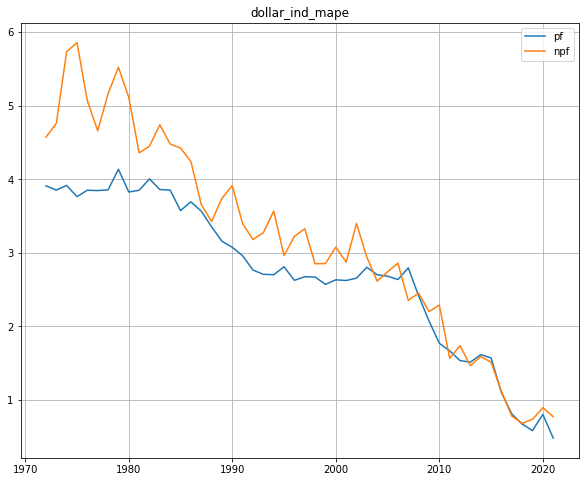

In [757]:
df = dollar_ind_various_term_mape_weekly

plt.figure(figsize=(10,8))
plt.title("dollar_ind_mape")
plt.plot(df["start_date_to_use"],df["pf_mape"] ,label= "pf")
plt.plot(df["start_date_to_use"],df["npf_mape"], label= "npf")
plt.grid()
plt.legend();

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]

  x[:, None]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]

  x = x[:, np.newaxis]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead

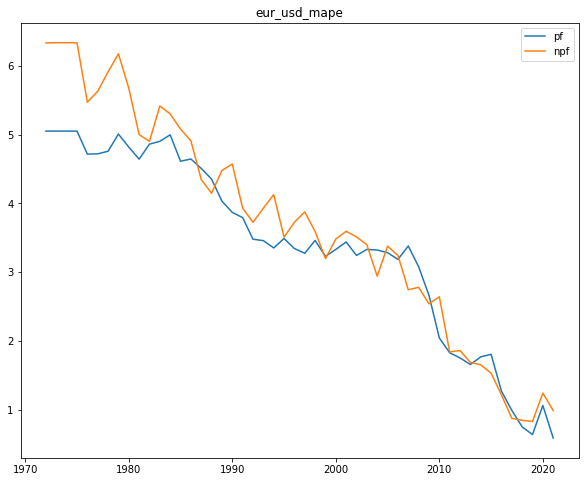

In [758]:
df = eur_usd_various_term_mape_weekly

plt.figure(figsize=(10,8))
plt.title("eur_usd_mape")
plt.plot(df["start_date_to_use"],df["pf_mape"] ,label= "pf")
plt.plot(df["start_date_to_use"],df["npf_mape"], label= "npf")
plt.legend();

In [ ]:
#以下過去セル(間違ってたやり方?)

# Prophet 

In [38]:
# Prophet 予測モデル構築
df1_prophet_model = Prophet( yearly_seasonality=True )#seasonality_mode='multiplicative' ,
df1_prophet_model.fit(df1_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]

  x[:, None]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]

  y = y[:, np.newaxis]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing in

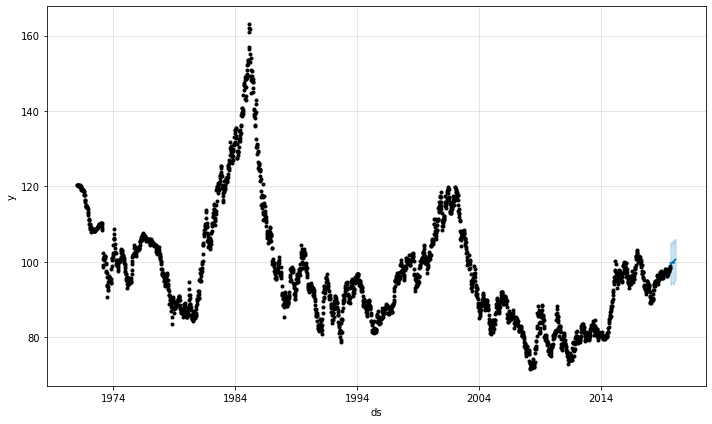

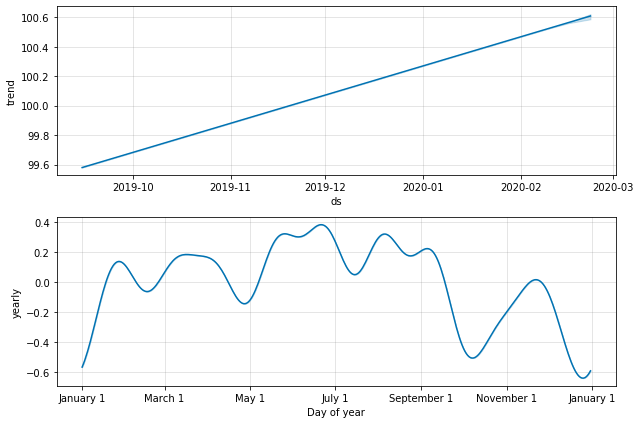

In [39]:
# Prophet 予測モデルの精度検証用データの生成
df1_future = df1_prophet_model.make_future_dataframe(periods=int(test_length/5*7), freq='D')#土休日も含めたperiodにする必要があるので、7/5倍すれば大体本来のtest_lengthになる
df1_pred = df1_prophet_model.predict(df1_future)

#土休日もpredに含まれてしまっているので、これを除外する
df1_pred = pd.merge(df1_pred ,df1_test, on = "ds", how="right")


# Prophet 予測モデルの予測結果（学習データ期間＋テストデータ期間）
df1_pred_plot = df1_prophet_model.plot(df1_pred)         #予想値（点は学習データの実測値）
df1_pmpc = df1_prophet_model.plot_components(df1_pred)   #モデルの要素分解

In [164]:
# テストデータに予測値を結合
df1_test['Prophet Predict'] = df1_pred.iloc[-test_length:].loc[:, 'yhat']

# Prophet 予測モデルの精度検証（テストデータ期間）
print('MAE:')
print(mean_absolute_error(df1_test['y'], df1_test['Prophet Predict'])) 
print('MAPE:')
print(mean(abs(df1_test['y'] - df1_test['Prophet Predict'])/df1_test['y']) *100)
df1_test.plot(title='Forecast evaluation',ylim=[0,15])

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  



MAE:


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

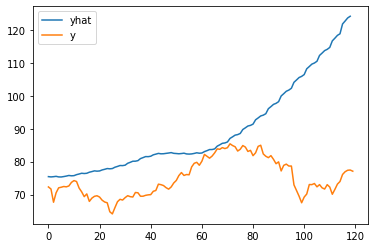

In [165]:
col_list = "yhat,y".split(",")
df1_pred = df1_pred.rename(columns = {"dollar_ind高値_y":"dollar_ind高値","eur_usd高値_y":"eur_usd高値"})

for col in col_list:
    plt.plot(df1_pred[col] , label=col)
plt.legend()

In [136]:
#外部変数の追加
df1 = feat_df.loc[: ,["高値","dollar_ind高値","eur_usd高値","date"]].rename(columns={"高値":"y" , "date":"ds"})

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]

  x[:, None]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]

  y = y[:, np.newaxis]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]

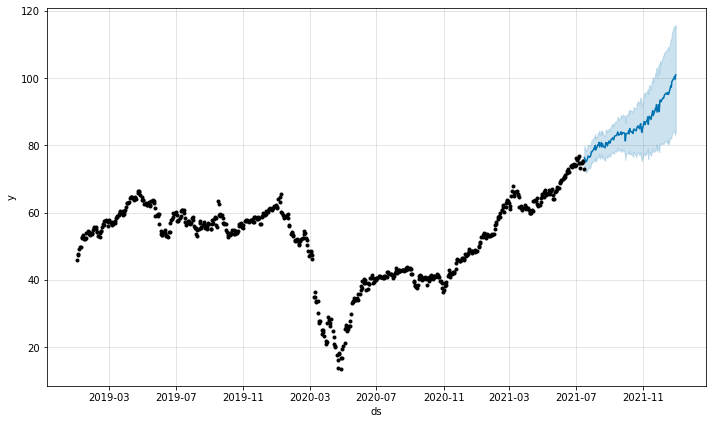

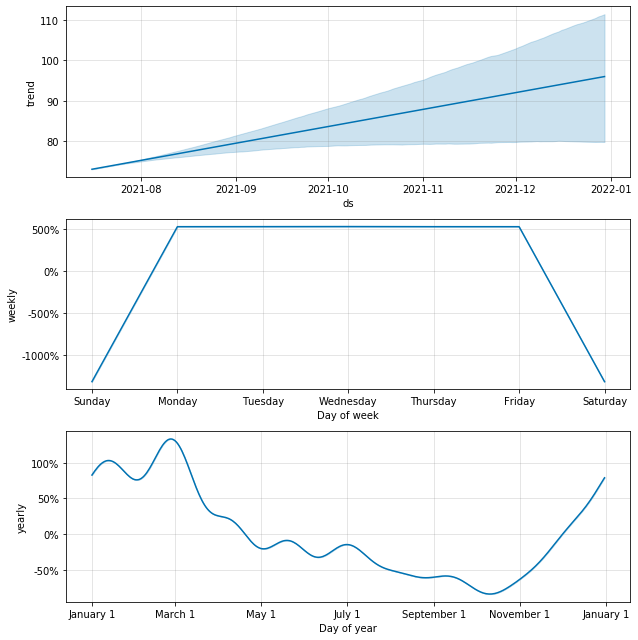

In [155]:
# 学習データとテストデータの分割
test_length = 120
df1_train = df1.iloc[:-test_length]
df1_test = df1.iloc[-test_length:]

# Prophet 予測モデル構築
m = Prophet()
m.add_regressor("dollar_ind高値")
m.add_regressor("eur_usd高値")
m.fit(df1_train)


df1_future = m.make_future_dataframe(periods=int(test_length/5*7), freq='D')#土休日も含めたperiodにする必要があるので、7/5倍すれば大体本来のtest_lengthになる
df1_future = pd.merge( df1_future, df1.loc[:, ["ds", "dollar_ind高値", "eur_usd高値"]], on="ds", how="inner")
df1_pred = m.predict(df1_future)

#土休日もpredに含まれてしまっているので、これを除外する
df1_pred = pd.merge(df1_pred ,df1_test, on = "ds", how="right")


# Prophet 予測モデルの予測結果（学習データ期間＋テストデータ期間）
df1_pred_plot = df1_prophet_model.plot(df1_pred)         #予想値（点は学習データの実測値）
df1_pmpc = df1_prophet_model.plot_components(df1_pred)   #モデルの要素分解


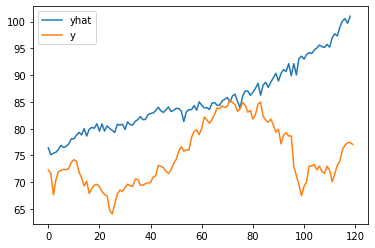

In [159]:
col_list = "yhat,y".split(",")
df1_pred = df1_pred.rename(columns = {"dollar_ind高値_y":"dollar_ind高値","eur_usd高値_y":"eur_usd高値"})

for col in col_list:
    plt.plot(df1_pred[col] , label=col)
plt.legend()

# NeuralProphet

In [166]:

# NeuralProphet 予測モデル構築
df1_nprophet_model = NeuralProphet(seasonality_mode='multiplicative')
df1_nprophet_model_result = df1_nprophet_model.fit(df1_train, freq="D")

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 200
INFO:NP.config:Auto-set epochs to 200


  0%|          | 0/241 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.46E-02, min: 1.73E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.46E-02, min: 1.73E+00


  0%|          | 0/241 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.01E-02, min: 1.58E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.01E-02, min: 1.58E+00


  0%|          | 0/241 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.96E-02, min: 2.66E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.96E-02, min: 2.66E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.46E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.46E-02
Epoch[200/200]: 100%|██████████| 200/200 [00:15<00:00, 12.72it/s, SmoothL1Loss=0.00128, MAE=1.96, RMSE=2.7, RegLoss=0] 


In [167]:
# NeuralProphet 予測モデルの精度検証用データの生成
df1_future = df1_nprophet_model.make_future_dataframe(df1_train, 
                                                      periods = int(test_length/5*7), #上記と同じ理由で5/7倍
                                                      n_historic_predictions=len(df1_train))
df1_pred = df1_nprophet_model.predict(df1_future)
df1_pred

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly
0,2019-01-01,45.95,48.176922,2.226922,42.657791,0.006802,0.183725
1,2019-01-02,47.78,48.355659,0.575659,42.751308,0.008243,0.184603
2,2019-01-03,47.49,48.443184,0.953184,42.844818,0.009608,0.182414
3,2019-01-04,49.22,48.520954,-0.699046,42.938335,0.010912,0.179958
4,2019-01-07,49.79,49.016788,-0.773212,43.218880,0.014613,0.181734
...,...,...,...,...,...,...,...
821,2021-12-26,NaN,59.511719,NaN,82.095337,-0.003522,-0.326622
822,2021-12-27,NaN,94.557144,NaN,82.204094,-0.001434,0.181734
823,2021-12-28,NaN,94.956276,NaN,82.312859,0.000520,0.183725
824,2021-12-29,NaN,95.271194,NaN,82.421616,0.002350,0.184603


WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]

  x[:, None]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]

  y = y[:, np.newaxis]



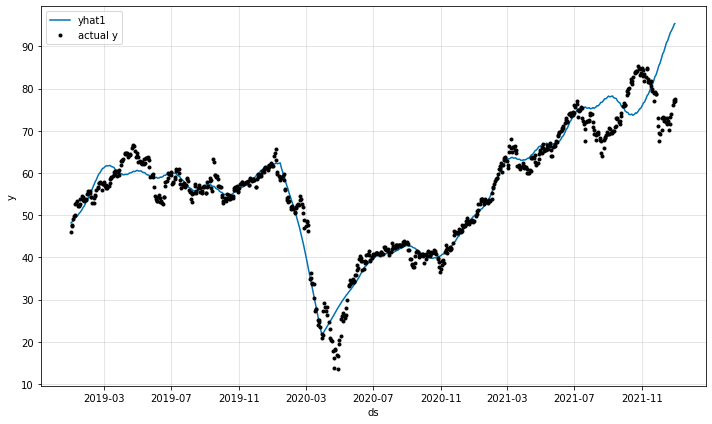

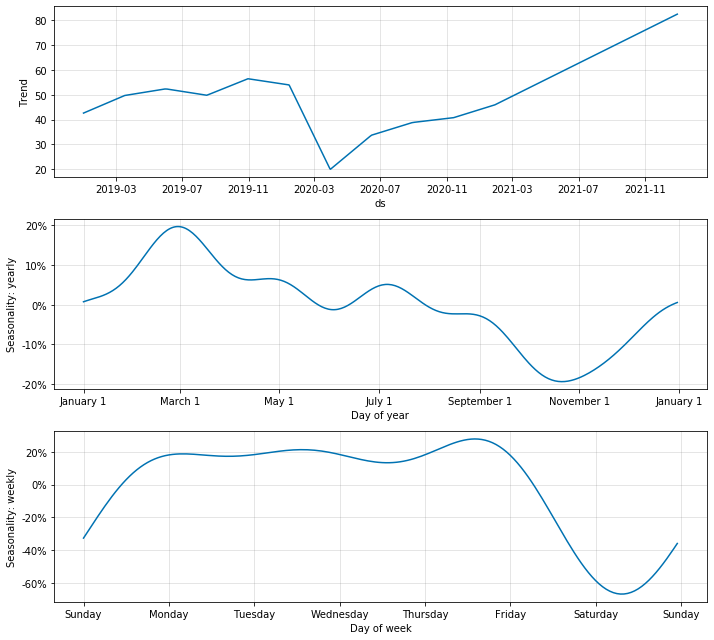

In [168]:
#土休日もpredに含まれてしまっているので、これを除外する
df1_pred = df1_pred.drop("y", axis=1)
df1_pred = pd.merge(df1_pred ,df1, on = "ds", how="right")

# NeuralProphet 予測モデルの予測結果（学習データ期間＋テストデータ期間）
df1_pred_plot = df1_nprophet_model.plot(df1_pred)         #予想値（点は学習データの実測値）
df1_pmpc = df1_nprophet_model.plot_components(df1_pred)   #モデルの要素分解

In [169]:
# テストデータに予測値を結合
df1_test['NeuralProphet Predict'] = df1_pred.iloc[-test_length:].loc[:, 'yhat1']

# NeuralProphet 予測モデルの精度検証（テストデータ期間）
print('MAE(Prophet):')
print(mean_absolute_error(df1_test['y'], df1_test['Prophet Predict'])) 
print('MAE(NeuralProphet):')
print(mean_absolute_error(df1_test['y'], df1_test['NeuralProphet Predict'])) 
print('----------------------------')
print('MAPE(Prophet):')
print(mean(abs(df1_test['y'] - df1_test['Prophet Predict'])/df1_test['y']) *100)
print('MAPE(NeuralProphet):')
print(mean(abs(df1_test['y'] - df1_test['NeuralProphet Predict'])/df1_test['y']) *100)
df1_test.plot(title='Forecast evaluation',ylim=[0,15])

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  



MAE(Prophet):


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

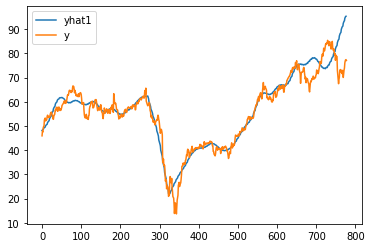

In [171]:
col_list = "yhat1,y".split(",")
df1_pred = df1_pred.rename(columns = {"dollar_ind高値_y":"dollar_ind高値","eur_usd高値_y":"eur_usd高値"})

for col in col_list:
    plt.plot(df1_pred[col] , label=col)
plt.legend()

In [13]:
#データセット
dollar_ind_weekly_1975 = pd.read_csv("input_data/米ドル指数_weekly_1975-2021.csv", encoding="utf_8")
eur_usd_weekly_1975 = pd.read_csv("input_data/EUR_USD_weekly_1975-2021.csv", encoding="utf_8")

dollar_ind_weekly_1975 = dollar_ind_weekly_1975.set_index("日付け")
eur_usd_weekly_1975 = eur_usd_weekly_1975.set_index("日付け")
eur_usd_weekly_1975

,終値,始値,高値,安値,前日比%
日付け,,,,,
1975年01月05日,1.3273,1.3273,1.3273,1.3273,0.68%
1975年01月12日,1.3268,1.3268,1.3268,1.3268,-0.04%
1975年01月19日,1.3543,1.3543,1.3543,1.3543,2.07%
1975年01月26日,1.3472,1.3472,1.3472,1.3472,-0.52%
1975年02月02日,1.3374,1.3374,1.3374,1.3374,-0.73%
...,...,...,...,...,...
2021年11月28日,1.1313,1.1309,1.1384,1.1236,-0.04%
2021年12月05日,1.1311,1.1321,1.1356,1.1228,-0.02%
2021年12月12日,1.1239,1.1316,1.1361,1.1221,-0.64%


,y,ds
日付け,,
2011年10月23日,75.07,2011-10-23
2011年10月30日,76.96,2011-10-30
2011年11月06日,76.94,2011-11-06
2011年11月13日,78.06,2011-11-13
2011年11月20日,79.69,2011-11-20
...,...,...
2021年11月28日,96.12,2021-11-28
2021年12月05日,96.10,2021-12-05
2021年12月12日,96.57,2021-12-12


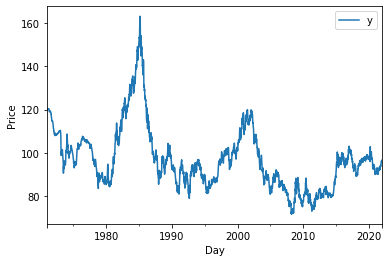

In [20]:
df =dollar_ind_weekly_1975
target_price = "終値"



#前処理
df["date"] = pd.to_datetime(df.index, format='%Y年%m月%d日')
df = df.sort_values(by = "date")
df1 = df.loc[: ,[target_price,"date"]].rename(columns={target_price:"y" , "date":"ds"})#高値で予測

#変化を描画し、周期性がありそうか確認
df1.set_index("ds").plot()
#plt.title('Page Views of Peyton Manning') #グラフタイトル
plt.ylabel('Price')             #タテ軸のラベル
plt.xlabel('Day')                          #ヨコ軸のラベル


# 学習データとテストデータの分割
test_length = int(len(df1)*0.2)
df1_train = df1.iloc[:-test_length]
df1_test = df1.iloc[-test_length:]
df1_test

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]

  x[:, None]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]

  y = y[:, np.newaxis]

WARNING - (py.warnings._showwarnmsg) - /Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/matp

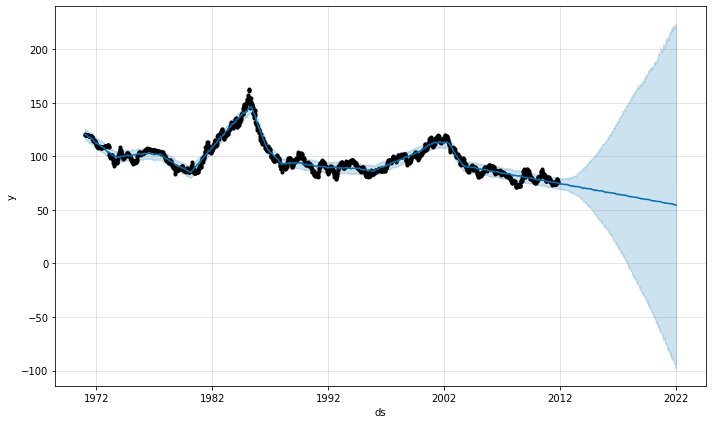

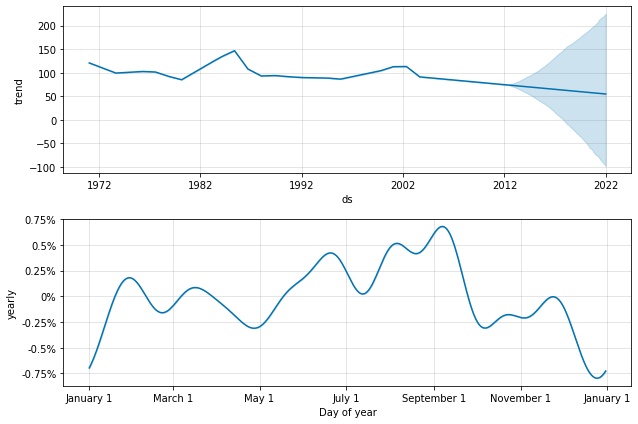

In [29]:
# Prophet 予測モデル構築
df1_prophet_model = Prophet(seasonality_mode='multiplicative' , yearly_seasonality=True )
df1_prophet_model.fit(df1_train)


# Prophet 予測モデルの精度検証用データの生成
df1_future = df1_prophet_model.make_future_dataframe(periods=test_length, freq='W')#土休日も含めたperiodにする必要があるので、7/5倍すれば大体本来のtest_lengthになる
df1_pred = df1_prophet_model.predict(df1_future)

#土休日もpredに含まれてしまっているので、これを除外する
#df1_pred = pd.merge(df1_pred ,df1_test, on = "ds", how="right")


# Prophet 予測モデルの予測結果（学習データ期間＋テストデータ期間）
df1_pred_plot = df1_prophet_model.plot(df1_pred)         #予想値（点は学習データの実測値）
df1_pmpc = df1_prophet_model.plot_components(df1_pred)   #モデルの要素分解

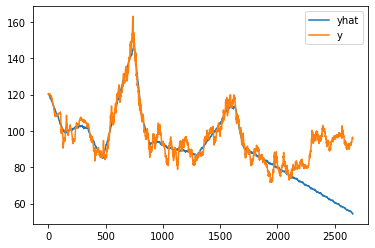

In [32]:
col_list = "yhat,y".split(",")
df1_pred_and_actual = pd.merge(df1_pred, df1 ,on="ds")

for col in col_list:
    plt.plot(df1_pred_and_actual[col] , label=col)
plt.legend()

In [27]:
df1_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1971-01-10,120.790905,115.500296,125.052305,120.790905,120.790905,-0.003917,-0.003917,-0.003917,-0.003917,-0.003917,-0.003917,0.0,0.0,0.0,120.317823
1,1971-01-17,120.632414,115.511713,125.387105,120.632414,120.632414,-0.000968,-0.000968,-0.000968,-0.000968,-0.000968,-0.000968,0.0,0.0,0.0,120.515639
2,1971-01-24,120.473923,116.024875,125.655856,120.473923,120.473923,0.001204,0.001204,0.001204,0.001204,0.001204,0.001204,0.0,0.0,0.0,120.618929
3,1971-01-31,120.315432,116.022748,125.396975,120.315432,120.315432,0.001778,0.001778,0.001778,0.001778,0.001778,0.001778,0.0,0.0,0.0,120.529394
4,1971-02-07,120.156941,115.405796,125.372860,120.156941,120.156941,0.000787,0.000787,0.000787,0.000787,0.000787,0.000787,0.0,0.0,0.0,120.251485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655,2021-11-28,54.879757,-115.558471,214.178616,-118.400624,214.414610,-0.000345,-0.000345,-0.000345,-0.000345,-0.000345,-0.000345,0.0,0.0,0.0,54.860821
2656,2021-12-05,54.841768,-118.324971,216.012997,-118.973554,214.894409,-0.002218,-0.002218,-0.002218,-0.002218,-0.002218,-0.002218,0.0,0.0,0.0,54.720102
2657,2021-12-12,54.803779,-119.149697,215.085112,-119.512154,215.473140,-0.005017,-0.005017,-0.005017,-0.005017,-0.005017,-0.005017,0.0,0.0,0.0,54.528827
2658,2021-12-19,54.765790,-120.630814,215.820600,-119.649563,216.051872,-0.007287,-0.007287,-0.007287,-0.007287,-0.007287,-0.007287,0.0,0.0,0.0,54.366696


In [30]:
df1_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1971-01-10,120.790905,115.395325,125.073385,120.790905,120.790905,-0.003917,-0.003917,-0.003917,-0.003917,-0.003917,-0.003917,0.0,0.0,0.0,120.317823
1,1971-01-17,120.632414,115.813234,125.437045,120.632414,120.632414,-0.000968,-0.000968,-0.000968,-0.000968,-0.000968,-0.000968,0.0,0.0,0.0,120.515639
2,1971-01-24,120.473923,116.027395,125.576490,120.473923,120.473923,0.001204,0.001204,0.001204,0.001204,0.001204,0.001204,0.0,0.0,0.0,120.618929
3,1971-01-31,120.315432,115.785546,125.476043,120.315432,120.315432,0.001778,0.001778,0.001778,0.001778,0.001778,0.001778,0.0,0.0,0.0,120.529394
4,1971-02-07,120.156941,115.410330,125.196758,120.156941,120.156941,0.000787,0.000787,0.000787,0.000787,0.000787,0.000787,0.0,0.0,0.0,120.251485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655,2021-11-28,54.879757,-97.376787,220.928943,-96.522709,223.363842,-0.000345,-0.000345,-0.000345,-0.000345,-0.000345,-0.000345,0.0,0.0,0.0,54.860821
2656,2021-12-05,54.841768,-95.387164,223.879435,-96.846689,223.858631,-0.002218,-0.002218,-0.002218,-0.002218,-0.002218,-0.002218,0.0,0.0,0.0,54.720102
2657,2021-12-12,54.803779,-98.114421,221.841275,-97.170669,224.263146,-0.005017,-0.005017,-0.005017,-0.005017,-0.005017,-0.005017,0.0,0.0,0.0,54.528827
2658,2021-12-19,54.765790,-92.772789,222.005616,-97.494648,224.571963,-0.007287,-0.007287,-0.007287,-0.007287,-0.007287,-0.007287,0.0,0.0,0.0,54.366696


In [ ]:
#AutoFeatRegressorは欠損があると動かないので、使いにくい、、、

In [66]:


# 特徴量生成モデル定義
model = AutoFeatRegressor(verbose=1)

# 特徴量生成（学習データ利用）
X_train_feature_creation = model.fit_transform(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [35]:
X_train_feature_creation

,dollar_ind終値,dollar_ind始値,dollar_ind高値,dollar_ind安値,eur_usd終値,eur_usd始値,eur_usd高値,eur_usd安値,exp(eur_usd安値)/eur_usd高値,dollar_ind終値**3*eur_usd高値**3,eur_usd終値/eur_usd高値,dollar_ind安値**3*eur_usd始値**3,dollar_ind高値/dollar_ind終値,1/(dollar_ind安値*eur_usd安値),exp(eur_usd終値)/eur_usd始値,dollar_ind高値/dollar_ind始値,dollar_ind安値/dollar_ind高値,eur_usd始値/eur_usd高値,dollar_ind安値/dollar_ind始値
0,96.09,96.72,96.77,95.75,1.1317,1.1209,1.1331,1.1205,2.706193,1.290742e+06,0.998764,1.236280e+06,1.007077,0.009321,2.766459,1.000517,0.989460,0.989233,0.989971
1,97.15,96.82,97.29,96.76,1.1220,1.1277,1.1283,1.1203,2.717162,1.317050e+06,0.994416,1.299177e+06,1.001441,0.009225,2.723233,1.004854,0.994552,0.999468,0.999380
2,97.54,97.56,97.85,97.31,1.1197,1.1199,1.1243,1.1179,2.720292,1.318848e+06,0.995909,1.294226e+06,1.003178,0.009193,2.735900,1.002973,0.994481,0.996086,0.997437
3,93.05,93.06,93.14,92.78,1.1845,1.1865,1.1901,1.1839,2.745224,1.357999e+06,0.995295,1.334032e+06,1.000967,0.009104,2.755206,1.000860,0.996135,0.996975,0.996991
4,92.87,93.23,93.25,92.56,1.1861,1.1802,1.1906,1.1793,2.731477,1.351836e+06,0.996220,1.303578e+06,1.004092,0.009161,2.774349,1.000215,0.992601,0.991265,0.992813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,93.46,93.22,93.51,92.99,1.1686,1.1726,1.1757,1.1683,2.735834,1.326682e+06,0.993961,1.296458e+06,1.000535,0.009205,2.743890,1.003111,0.994439,0.997363,0.997533
540,92.27,92.04,92.31,91.82,1.1835,1.1864,1.1901,1.1832,2.743303,1.324134e+06,0.994454,1.292722e+06,1.000434,0.009205,2.752684,1.002934,0.994692,0.996891,0.997610
541,90.71,90.98,90.98,90.42,1.2143,1.2131,1.2177,1.2115,2.758084,1.347679e+06,0.997208,1.319725e+06,1.002977,0.009129,2.776305,1.000000,0.993845,0.996222,0.993845
542,100.04,100.23,100.32,99.83,1.0828,1.0809,1.0862,1.0808,2.713162,1.283070e+06,0.996870,1.256434e+06,1.002799,0.009268,2.731924,1.000898,0.995116,0.995121,0.996009


In [10]:
# テストデータの特徴量生成
X_test_feature_creation = model.transform(X_test)

# モデル構築
model_1 = LinearRegression().fit(X_train,y_train)
model_2 = LinearRegression().fit(X_train_feature_creation, y_train)

# 評価（R2）
print("model_1   R^2: %.4f" % r2_score(y_test, model_1.predict(X_test)) )
print("model_2   R^2: %.4f" % r2_score(y_test, model_2.predict(X_test_feature_creation)))
print("LassoLars R^2: %.4f" % r2_score(y_test, model.predict(X_test_feature_creation)))

[AutoFeat] Computing 11 new features.
[AutoFeat]    11/   11 new features ...done.
model_1   R^2: 0.3715
model_2   R^2: 0.5609
LassoLars R^2: 0.4940


/Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


In [13]:
# 必要なライブラリの読み込み
from tpot import TPOTRegressor
# TPOTRegressorの設定
tpot = TPOTRegressor(scoring='r2',
                     generations=5,
                     population_size=25,
                     random_state=42,
                     verbosity=2,
                     n_jobs=-1)
# モデル構築
tpot.fit(X_train, y_train)
# 評価（R2）
r2_score(y_test, tpot.predict(X_test))

/Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")



Generation 1 - Current best internal CV score: 0.697422360969947

Generation 2 - Current best internal CV score: 0.697422360969947

Generation 3 - Current best internal CV score: 0.697422360969947

Generation 4 - Current best internal CV score: 0.697422360969947

Generation 5 - Current best internal CV score: 0.7314907991469293

Best pipeline: RandomForestRegressor(RidgeCV(RidgeCV(input_matrix)), bootstrap=False, max_features=0.3, min_samples_leaf=5, min_samples_split=2, n_estimators=100)


/Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  "X does not have valid feature names, but"


0.679692137735175

In [19]:
y_and_pred_df = pd.DataFrame([y_test.values,tpot.predict(X_test)] , columns=(["y_test", "y_pred"]))
y_and_pred_df

/Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  "X does not have valid feature names, but"


ValueError: 2 columns passed, passed data had 234 columns

In [17]:
[,tpot.predict(X_test)]

/Users/ns_mac/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  "X does not have valid feature names, but"


[日付け
 2019年09月13日    54.85
 2019年09月25日    56.49
 2019年11月26日    58.41
 2019年07月08日    57.66
 2020年02月12日    51.17
                ...  
 2019年09月04日    56.26
 2021年02月15日    60.09
 2021年03月08日    65.05
 2019年10月04日    52.81
 2020年08月06日    41.95
 Name: 終値, Length: 234, dtype: float64,
 array([51.95242476, 51.70591377, 55.81263635, 58.7380871 , 51.00807008,
        58.3042806 , 47.70816024, 58.89217278, 60.73002623, 42.09375357,
        40.77624591, 59.21144865, 59.26543175, 47.03738071, 55.18580512,
        67.24650353, 60.8323627 , 68.98773302, 60.74355889, 67.46450944,
        45.15221952, 51.32715933, 70.83284417, 60.58548984, 70.59380952,
        50.53830583, 57.37311302, 24.93622663, 52.65159274, 78.87345468,
        46.39889798, 68.06782306, 61.88967306, 56.13263131, 54.42034258,
        53.97317476, 49.47895365, 59.26240361, 41.34292063, 55.2915823 ,
        41.48933651, 48.93078417, 69.37061845, 57.43411639, 60.95112067,
        48.85589151, 40.39613056, 52.68858413, 68.873351

In [20]:
y_test.values

array([ 54.85,  56.49,  58.41,  57.66,  51.17,  64.01,  39.82,  60.93,
        53.13,  52.64,  41.27,  56.77,  54.41,  52.59,  53.8 ,  66.85,
        62.7 ,  75.29,  45.53,  73.95,  74.83,  59.33,  70.45,  63.05,
        69.95,  52.45,  63.76,  19.87,  38.94,  81.27,  28.7 ,  68.59,
        73.06,  54.93,  56.96,  37.14,  56.79,  59.61,  40.97,  57.12,
        39.2 ,  47.96,  66.42,  56.25,  61.28,  48.52,  42.62,  38.19,
        70.46,  55.48,  41.28,  61.42,  83.76,  59.38,  60.  ,  37.26,
        40.81,  55.78,  56.22,  53.62,  42.15,  79.01,  53.76,  80.88,
        78.36,  55.59,  48.  ,  40.88,  51.43,  55.35,  52.36,  59.14,
        47.02,  58.36,  40.22,  59.56,  55.69,  56.92,  63.27,  47.74,
        82.28,  56.66,  54.5 ,  66.59,  54.19,  41.12,  63.3 ,  55.59,
        49.1 ,  40.9 ,  71.65,  12.34,  69.29,  72.38,  22.41,  56.65,
        34.36,  39.6 ,  53.55,  76.1 ,  31.73,  56.35,  75.03,  56.23,
        54.69,  41.11,  69.3 ,  53.78,  54.47,  52.05,  53.95,  60.55,
      